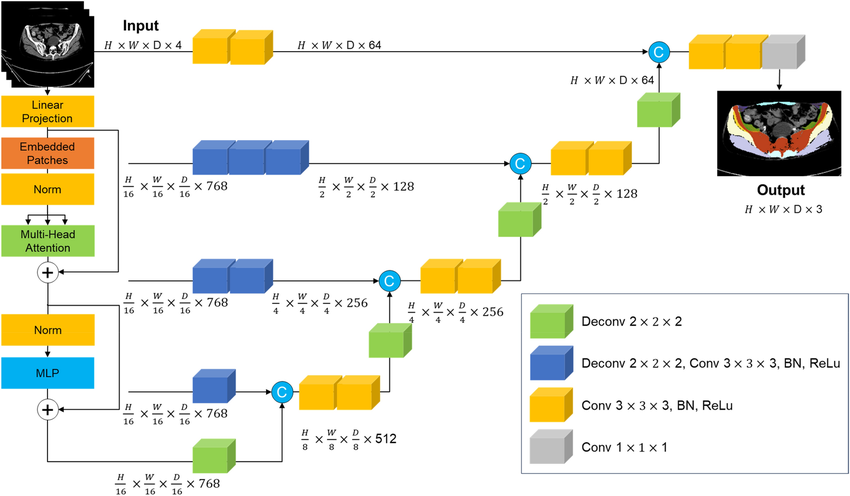
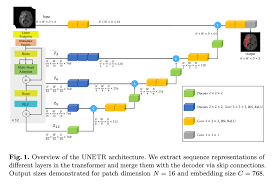

In [1]:
%pip install patchify

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import tensorflow as tf
print(tf.__version__)
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from math import log2


import numpy as np
import cv2
import os
import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from patchify import patchify

2.17.1


# MAINSTREAM

In [3]:
def mlp(x, config_files):
    x = L.Dense(config_files['mlp_dim'], activation="gelu")(x)
    x = L.Dropout(config_files['dropout_rate'])(x)
    x = L.Dense(config_files['hidden_dim'])(x)
    x = L.Dropout(config_files['dropout_rate'])(x)
    return x

def transformer_encoder(x, config_files):
    skip_1 = x
    x = L.LayerNormalization()(x)
    x = L.MultiHeadAttention(
        num_heads = config_files['num_heads'],
        key_dim = config_files['hidden_dim'],
    )(x,x)
    x = L.Add()([x, skip_1])

    skip_2 = x
    x = L.LayerNormalization()(x)
    x = mlp(x, config_files)
    x = L.Add()([x, skip_2])

    return x

def conv_block(x, num_filters, kernel_size = 3):
    x = L.Conv2D(num_filters, kernel_size = kernel_size, padding = 'same')(x)
    x = L.BatchNormalization()(x)
    x = L.ReLU()(x)

    return x

def deconv_block(x, num_filters):
    x = L.Conv2DTranspose(num_filters, kernel_size= 2, padding="same", strides=2)(x)
    return x


def Unetr(config_files):

    """ Input """
    input_shape = (config_files['num_patches'], config_files['patch_size'] * config_files['patch_size'] * config_files['num_channels'])
    input = L.Input(input_shape)


    """ Patch + Position Embeddings """
    Embedded_patch = L.Dense(config_files['hidden_dim'])(input)
    print(input.shape ,Embedded_patch.shape) # shape = (None, 256, 768)

    position = tf.range(start=0, limit= config_files['num_patches'], delta=1) # 256 position, ranging from 0 to 255
    print(position)

    pos_embedded = L.Embedding(input_dim= config_files["num_patches"], output_dim=config_files["hidden_dim"])(position)
    print(pos_embedded.shape)

    x = Embedded_patch + pos_embedded


    """ Transformer Encoder """
    skip_connection_index = [3,6,9,12]
    skip_connections = []

    for i in range (1, config_files['num_layers'] + 1): # there are 12 layers 
        x = transformer_encoder(x, config_files)

        if i in skip_connection_index:
            skip_connections.append(x)
    print(x.shape)


    """ CNN Decoder """
    z3, z6, z9, z12 = skip_connections
    
    size = config_files['image_size'] // config_files['patch_size'] # (H/16,W/16)

    # Resizing shape of skip connection
    z0 = L.Reshape((config_files['image_size'], config_files['image_size'], config_files['num_channels']))(input)
    z3 = L.Reshape((size, size, config_files['hidden_dim']))(z3) # (H/16,W/16,D)  NOTE: D is dimension
    z6 = L.Reshape((size, size, config_files['hidden_dim']))(z6) # (H/16,W/16,D)
    z9 = L.Reshape((size, size, config_files['hidden_dim']))(z9) # (H/16,W/16,D)
    z12 = L.Reshape((size, size, config_files['hidden_dim']))(z12) # (H/16,W/16,D)
    print(z0.shape,z3.shape, z6.shape, z9.shape, z12.shape)


    # Additional layers for handling different patch sizes
    total_upscale_factor = int(log2(config_files["patch_size"]))
    upscale = total_upscale_factor - 4

    if upscale >= 2: ## Patch size 16 or greater
        z3 = deconv_block(z3, z3.shape[-1], strides=2**upscale)
        z6 = deconv_block(z6, z6.shape[-1], strides=2**upscale)
        z9 = deconv_block(z9, z9.shape[-1], strides=2**upscale)
        z12 = deconv_block(z12, z12.shape[-1], strides=2**upscale)
        # print(z3.shape, z6.shape, z9.shape, z12.shape)

    if upscale < 0: ## Patch size less than 16
        p = 2**abs(upscale)
        z3 = L.MaxPool2D((p, p))(z3)
        z6 = L.MaxPool2D((p, p))(z6)
        z9 = L.MaxPool2D((p, p))(z9)
        z12 = L.MaxPool2D((p, p))(z12)



    # Decoder layer 1
    x = deconv_block(z12, 512)

    s = deconv_block(z9, 512) # Process demonstrated in blue box
    s = conv_block(s, 512) # Process demonstrated in blue box
    print(x.shape, s.shape)

    x = L.Concatenate()([x,s])
    print(x.shape)

    x = conv_block(x, 512) # Process demonstrated in yellow box
    x = conv_block(x, 512) # Process demonstrated in yellow box
    print(x.shape)



    # Decoder layer 2
    x = deconv_block(x, 256)

    s = deconv_block(z6, 256) # Process demonstrated in blue box
    s = conv_block(s, 256) # Process demonstrated in blue box
    s = deconv_block(s, 256) # Process demonstrated in blue box
    s = conv_block(s, 256) # Process demonstrated in blue box
    print(x.shape, s.shape)

    x = L.Concatenate()([x,s])
    print(x.shape)

    x = conv_block(x, 256) # Process demonstrated in yellow box
    x = conv_block(x, 256) # Process demonstrated in yellow box
    print(x.shape)


    # Decoder layer 3
    x = deconv_block(x, 128)

    s = deconv_block(z3, 128) # Process demonstrated in blue box
    s = conv_block(s, 128) # Process demonstrated in blue box
    s = deconv_block(s, 128) # Process demonstrated in blue box
    s = conv_block(s, 128) # Process demonstrated in blue box
    s = deconv_block(s, 128) # Process demonstrated in blue box
    s = conv_block(s, 128) # Process demonstrated in blue box

    x = L.Concatenate()([x,s])
    print(x.shape)

    x = conv_block(x, 128) # Process demonstrated in yellow box
    x = conv_block(x, 128) # Process demonstrated in yellow box
    print(x.shape, z0.shape)


    # Decoder layer 4
    x = deconv_block(x, 64)

    s = conv_block(z0, 64)
    s = conv_block(s, 64)

    x = L.Concatenate()([x,s])
    print(x.shape)

    x = conv_block(x, 64) # Process demonstrated in yellow box
    x = conv_block(x, 64) # Process demonstrated in yellow box

    output = L.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)
    print(output.shape)

    return Model(input, output, name="Unetr_2D")


if __name__ == '__main__':
    config = {}
    config['image_size'] = 512
    config['num_layers'] = 12
    config['hidden_dim'] = 64
    config['mlp_dim'] = 128
    config['num_heads'] = 6
    config['dropout_rate'] = 0.1
    config['patch_size'] = 1
    config['num_patches'] = (config['image_size']**2) // (config['patch_size']**2)
    config['num_channels'] = 3

    model = Unetr(config)
    model.summary()

(None, 262144, 3) (None, 262144, 64)
tf.Tensor([     0      1      2 ... 262141 262142 262143], shape=(262144,), dtype=int32)
(262144, 64)
(None, 262144, 64)
(None, 512, 512, 3) (None, 512, 512, 64) (None, 512, 512, 64) (None, 512, 512, 64) (None, 512, 512, 64)
(None, 64, 64, 512) (None, 64, 64, 512)
(None, 64, 64, 1024)
(None, 64, 64, 512)
(None, 128, 128, 256) (None, 128, 128, 256)
(None, 128, 128, 512)
(None, 128, 128, 256)
(None, 256, 256, 256)
(None, 256, 256, 128) (None, 512, 512, 3)
(None, 512, 512, 128)
(None, 512, 512, 1)


Model: "Unetr_2D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 262144, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 262144, 64)     │            256 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 262144, 64)     │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 262144, 64)     │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 262144, 64)     │         99,520 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 262144, 64)     │              0 │ multi_head_attention[… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 262144, 64)     │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 262144, 128)    │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 262144, 128)    │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 262144, 64)     │          8,256 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 262144, 64)     │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 262144, 64)     │              0 │ dropout_2[0][0],       │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 262144, 64)     │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 262144, 64)     │         99,520 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 262144, 64)     │              0 │ multi_head_attention_… │
│                           │                        │                │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3

 Total params: 16,278,209 (62.10 MB)

 Trainable params: 16,271,297 (62.07 MB)

 Non-trainable params: 6,912 (27.00 KB)

# TRAINING STEP

In [4]:
config = {}
config['image_size'] = 256
config['num_layers'] = 12
config['hidden_dim'] = 128
config['mlp_dim'] = 32
config['num_heads'] = 6
config['dropout_rate'] = 0.1
config['patch_size'] = 16
config['num_patches'] = (config['image_size']**2) // (config['patch_size']**2)
config['num_channels'] = 3

config["flat_patches_shape"] = (
    config["num_patches"],
    config["patch_size"]*config["patch_size"]*config["num_channels"]
)

In [5]:
# Create directory for saving weights
def create_dir(path): 
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
""" Load Data  Function """

def load_data(path, split = 0.1):
    """ Load the Images and Masks"""
    train_x = sorted(glob.glob(os.path.join(path, "augmented_scans", "*.png")))
    train_y = sorted(glob.glob(os.path.join(path, "augmented_masks", "*.png")))

    valid_x = sorted(glob.glob(os.path.join("/kaggle/input/val-test-for-lung-segmentation/valid_2", "origin_2", "*.png")))
    valid_y = sorted(glob.glob(os.path.join("/kaggle/input/val-test-for-lung-segmentation/valid_2", "mask_2", "*.png")))

    test_x = sorted(glob.glob(os.path.join("/kaggle/input/val-test-for-lung-segmentation/test_2", "origin_2", "*.png")))
    test_y = sorted(glob.glob(os.path.join("/kaggle/input/val-test-for-lung-segmentation/test_2", "mask_2", "*.png")))
    


    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)


""" Testing: Load Data """

dataset_path = r"/kaggle/input/training-data-for-lung-canceraugmented"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)
print(f"Train: \t{len(train_x)} - {len(train_y)}")
print(f"Valid: \t{len(valid_x)} - {len(valid_y)}")
print(f"Test: \t{len(test_x)} - {len(test_y)}")


Train: 	3108 - 3108
Valid: 	98 - 98
Test: 	97 - 97


In [7]:

def read_image(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    if image is None:
        print(f"Warning: Unable to load image at path: {path}")
        return np.zeros((config['image_size'], config['image_size'], config['num_channels']), dtype=np.float32)
    image = cv2.resize(image, (config["image_size"], config["image_size"]))
    image = image / 255.0

    patch_shape = (config["patch_size"], config["patch_size"], config["num_channels"])
    patches = patchify(image, patch_shape, config["patch_size"])
    patches = np.reshape(patches, config["flat_patches_shape"])
    patches = patches.astype(np.float32)

    return patches


def read_mask(path):
    path = path.decode()
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (config['image_size'], config['image_size']))
    mask = mask/255.0
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)

    return mask

In [8]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape(config["flat_patches_shape"])
    y.set_shape([config["image_size"], config["image_size"], 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.map(tf_parse).batch(batch).prefetch(10)
    return ds

In [9]:
import numpy as np
import tensorflow as tf
from keras.saving import register_keras_serializable

smooth = 1e-15


def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


# Intersection over Union (IoU)
@register_keras_serializable()
def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

@register_keras_serializable()
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Precision
@register_keras_serializable()
def precision(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_positives = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)
    return (true_positives + smooth) / (predicted_positives + smooth)

# Recall (Sensitivity)
@register_keras_serializable()
def recall(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_positives = tf.reduce_sum(y_true * y_pred)
    actual_positives = tf.reduce_sum(y_true)
    return (true_positives + smooth) / (actual_positives + smooth)

# F1 Score
@register_keras_serializable()
def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * (p * r) / (p + r + smooth)



In [10]:

if __name__ == '__main__':
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for saving weights """	
    create_dir("/kaggle/working/save_weights_dataset_2")


    """ Hyperparameters """
    batch_size = 8
    learning_rate = 0.1
    num_epochs = 100
    model_path = os.path.join("/kaggle/working/save_weights_dataset_2", "Unettr_2D.keras")
    csv_path = os.path.join("/kaggle/working/save_weights_dataset_2", "history_2.csv")


    """ Load the Dataset """
    dataset_path = r"/kaggle/input/training-data-for-lung-canceraugmented"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)
    print(f"Train: \t{len(train_x)} - {len(train_y)}")
    print(f"Valid: \t{len(valid_x)} - {len(valid_y)}")
    print(f"Test: \t{len(test_x)} - {len(test_y)}")
    
    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)


    """ Model Implementation """
    model = Unetr(config)
    model.compile(loss=dice_loss, optimizer=SGD(learning_rate), metrics= [dice_coef, iou_coef, rmse, precision, recall, f1_score, 'acc'])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
    ]
    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Train: 	3108 - 3108
Valid: 	98 - 98
Test: 	97 - 97
(None, 256, 768) (None, 256, 128)
tf.Tensor(
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222

Index(['epoch', 'acc', 'dice_coef', 'f1_score', 'iou_coef', 'learning_rate',
       'loss', 'precision', 'recall', 'rmse', 'val_acc', 'val_dice_coef',
       'val_f1_score', 'val_iou_coef', 'val_loss', 'val_precision',
       'val_recall', 'val_rmse'],
      dtype='object')


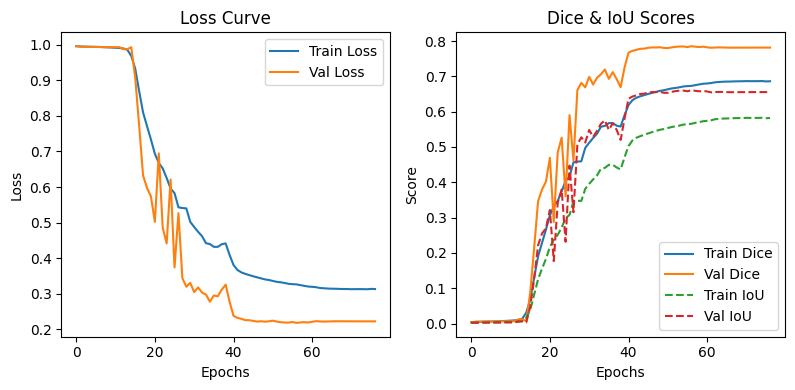

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training history from CSV
csv_path = "/kaggle/working/save_weights_dataset_2/history_2.csv"
history_df = pd.read_csv(csv_path)

# Display available columns
print(history_df.columns)

# Extract training history
train_loss = history_df['loss']
val_loss = history_df['val_loss']
train_dice = history_df['dice_coef']
val_dice = history_df['val_dice_coef']
train_iou = history_df['iou_coef']
val_iou = history_df['val_iou_coef']

epochs_range = range(len(train_loss))

# Create a plot with proper subplots
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Dice and IoU scores curve
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_dice, label='Train Dice')
plt.plot(epochs_range, val_dice, label='Val Dice')
plt.plot(epochs_range, train_iou, '--', label='Train IoU')
plt.plot(epochs_range, val_iou, '--', label='Val IoU')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.title('Dice & IoU Scores')

plt.tight_layout()
plt.show()


In [12]:
dataset_path = r"/kaggle/input/training-data-for-lung-canceraugmented"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)
print(f"Train: \t{len(train_x)} - {len(train_y)}")
print(f"Valid: \t{len(valid_x)} - {len(valid_y)}")
print(f"Test: \t{len(test_x)} - {len(test_y)}")

test_dataset = tf_dataset(test_x, test_y, batch=8)  # Adjust batch size as needed
train_results = model.evaluate(train_dataset, verbose=1)
valid_results = model.evaluate(valid_dataset, verbose=1)
test_results = model.evaluate(test_dataset, verbose=1)

print(train_results)  # Should return a list with values for each metric
print(valid_results)
print(test_results)

Train: 	3108 - 3108
Valid: 	98 - 98
Test: 	97 - 97
389/389 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - acc: 0.9996 - dice_coef: 0.6672 - f1_score: 0.6685 - iou_coef: 0.5645 - loss: 0.3328 - precision: 0.8509 - recall: 0.6217 - rmse: 0.0188
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - acc: 0.9994 - dice_coef: 0.7336 - f1_score: 0.7346 - iou_coef: 0.5986 - loss: 0.2669 - precision: 0.8196 - recall: 0.6784 - rmse: 0.0193
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 586ms/step - acc: 0.9992 - dice_coef: 0.8063 - f1_score: 0.8062 - iou_coef: 0.6772 - loss: 0.1937 - precision: 0.8492 - recall: 0.7727 - rmse: 0.0223
[0.3223192095756531, 0.6768094301223755, 0.5717218518257141, 0.01907237246632576, 0.8558337092399597, 0.6298432350158691, 0.6780371069908142, 0.9995793700218201]
[0.22202154994010925, 0.7815026640892029, 0.6554816365242004, 0.01921081356704235, 0.8348487019538879, 0.7463628053665161, 0.782035768032074, 0.9993362426757812]
[0.19232910871505737, 0.8074546456336975, 0.6797608137130737, 0.02200816199183464, 

In [14]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from tqdm import tqdm

""" UNETR  Configration """
cf = {}
cf["image_size"] = 256
cf["num_channels"] = 3
cf["num_layers"] = 12
cf["hidden_dim"] = 128
cf["mlp_dim"] = 32
cf["num_heads"] = 6
cf["dropout_rate"] = 0.1
cf["patch_size"] = 16
cf["num_patches"] = (cf["image_size"]**2)//(cf["patch_size"]**2)
cf["flat_patches_shape"] = (
    cf["num_patches"],
    cf["patch_size"]*cf["patch_size"]*cf["num_channels"]
)


if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir(f"results")

    """ Load the model """
    model_path = os.path.join("/kaggle/working/save_weights_dataset_2", "/kaggle/working/save_weights_dataset_2/Unettr_2D.keras")
    from keras.models import load_model

    custom_objects = {
        "dice_loss": dice_loss,
        "dice_coef": dice_coef,
        "iou_coef": iou_coef,
        "precision" : precision,
        "recall" : recall,
        "f1_score" : f1_score
    }
    
    model = load_model(model_path, custom_objects=custom_objects)


    """ Dataset """
    dataset_path = "/kaggle/input/training-data-for-lung-canceraugmented"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)

    print(f"Train: \t{len(train_x)} - {len(train_y)}")
    print(f"Valid: \t{len(valid_x)} - {len(valid_y)}")
    print(f"Test: \t{len(test_x)} - {len(test_y)}")

    """ Prediction """
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        """ Extracting the name """
        name = x.split("/")[-1]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
        x = image / 255.0

        patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
        patches = patchify(x, patch_shape, cf["patch_size"])
        patches = np.reshape(patches, cf["flat_patches_shape"])
        patches = patches.astype(np.float32)
        patches = np.expand_dims(patches, axis=0)

        """ Read Mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (cf["image_size"], cf["image_size"]))
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=-1)
        mask = np.concatenate([mask, mask, mask], axis=-1)

        """ Prediction """
        pred = model.predict(patches, verbose=0)[0]
        pred = np.concatenate([pred, pred, pred], axis=-1)

        """ Save final mask """
        line = np.ones((cf["image_size"], 10, 3)) * 255
        cat_images = np.concatenate([image, line, mask*255, line, pred*255], axis=1)
        save_image_path = os.path.join("results",  name)
        cv2.imwrite(save_image_path, cat_images)


Train: 	3108 - 3108
Valid: 	98 - 98
Test: 	97 - 97


100%|██████████| 97/97 [00:13<00:00,  7.44it/s]


Train: 	3108 - 3108
Valid: 	98 - 98
Test: 	97 - 97


  0%|          | 0/97 [00:00<?, ?it/s]

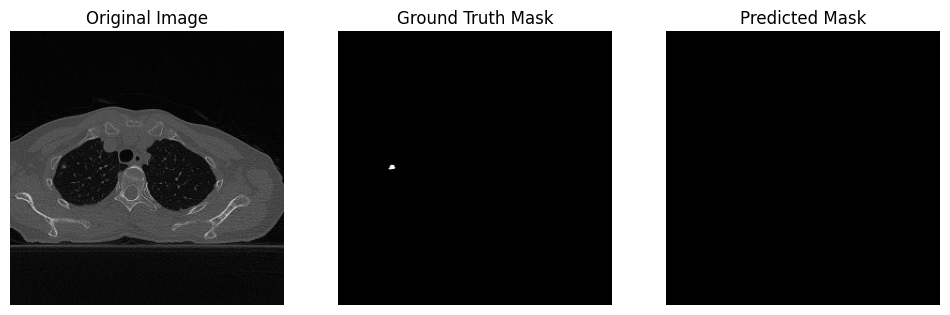

  1%|          | 1/97 [00:04<07:53,  4.93s/it]

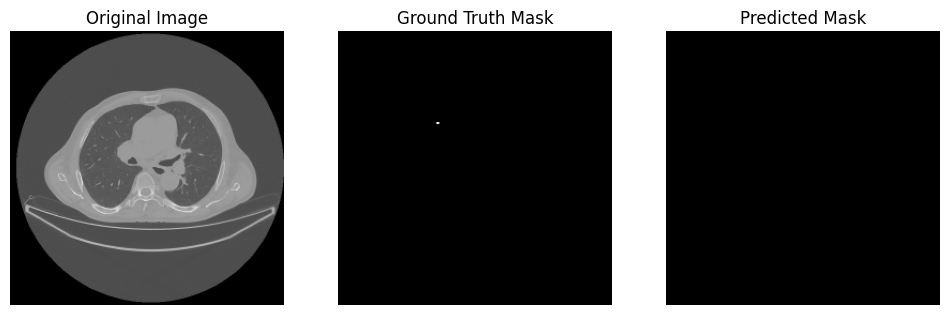

  2%|▏         | 2/97 [00:05<03:29,  2.20s/it]

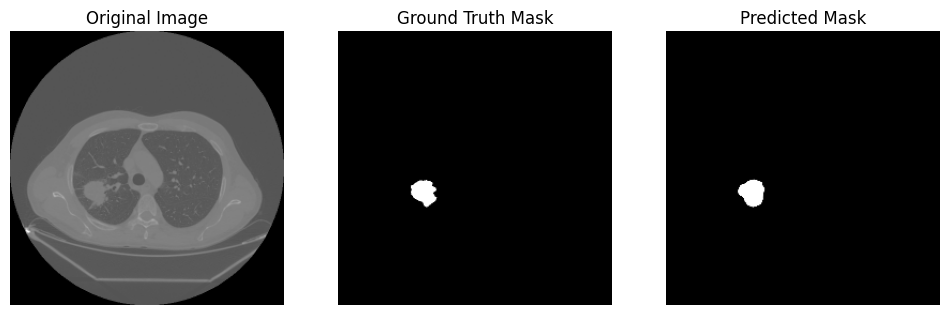

  3%|▎         | 3/97 [00:05<02:22,  1.52s/it]

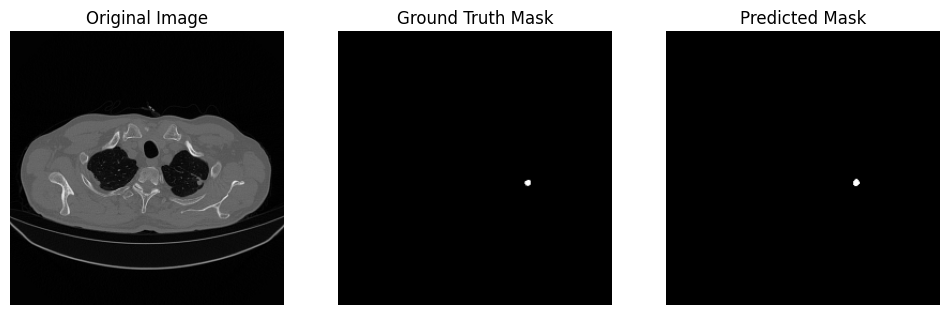

  4%|▍         | 4/97 [00:06<01:36,  1.04s/it]

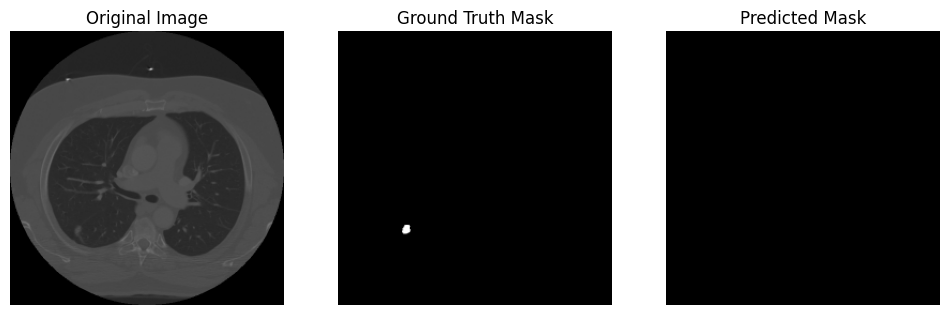

  5%|▌         | 5/97 [00:06<01:11,  1.29it/s]

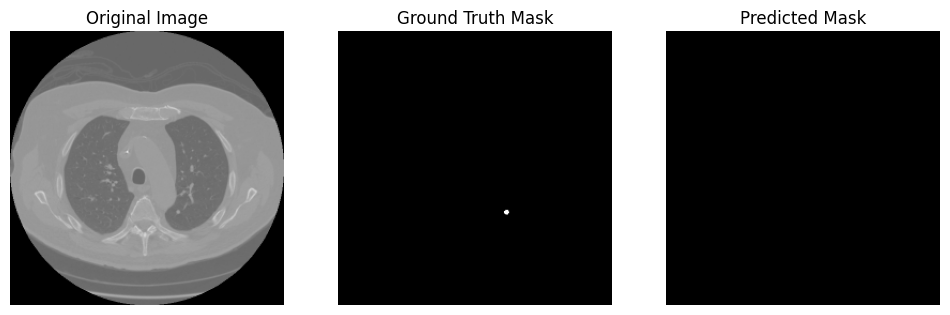

  6%|▌         | 6/97 [00:06<00:56,  1.60it/s]

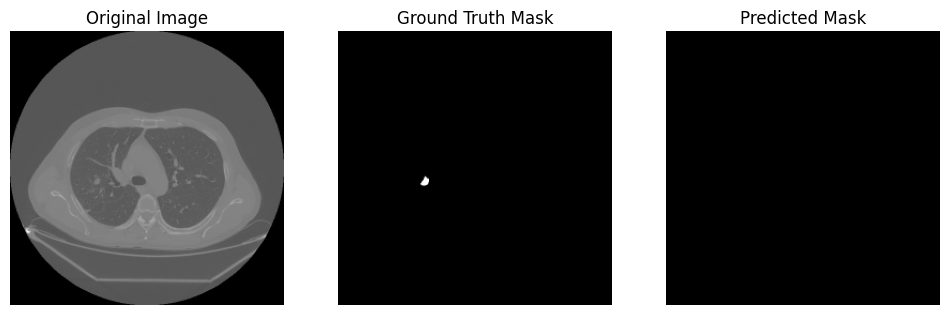

  7%|▋         | 7/97 [00:07<00:47,  1.88it/s]

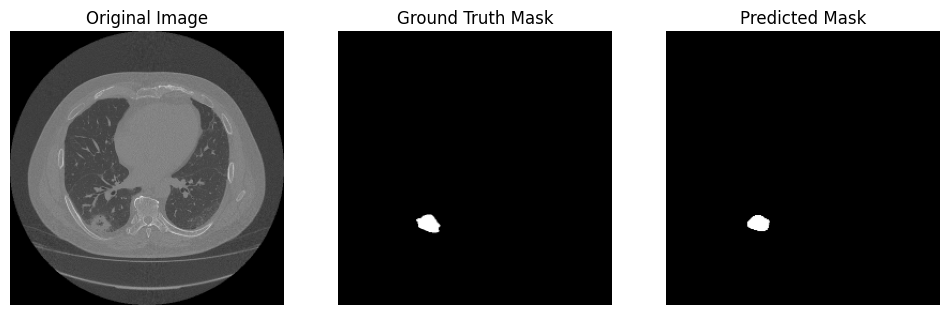

  8%|▊         | 8/97 [00:07<00:41,  2.14it/s]

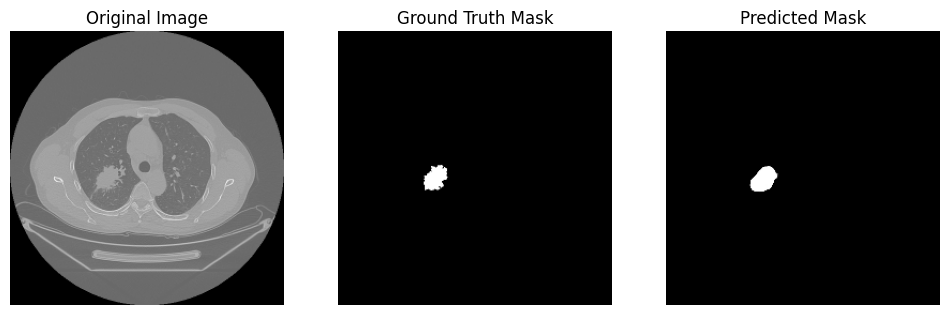

  9%|▉         | 9/97 [00:07<00:37,  2.37it/s]

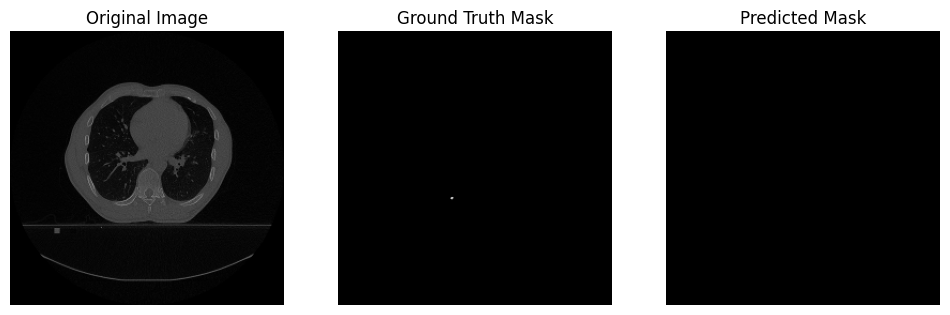

 10%|█         | 10/97 [00:08<00:34,  2.53it/s]

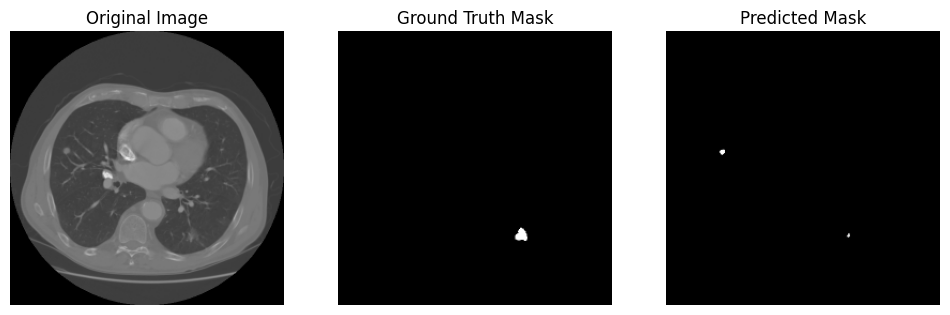

 11%|█▏        | 11/97 [00:08<00:31,  2.73it/s]

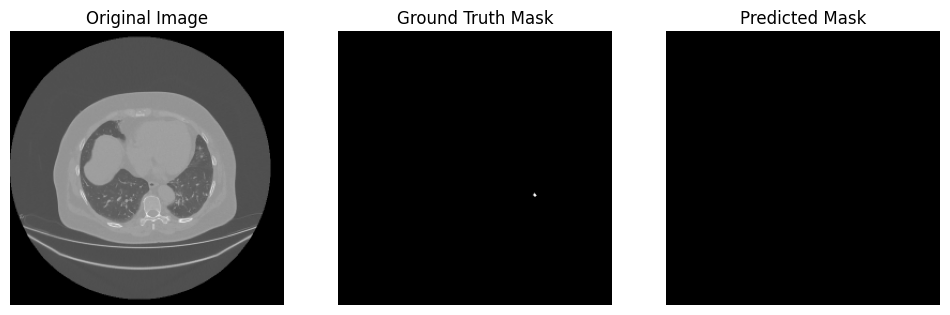

 12%|█▏        | 12/97 [00:08<00:29,  2.89it/s]

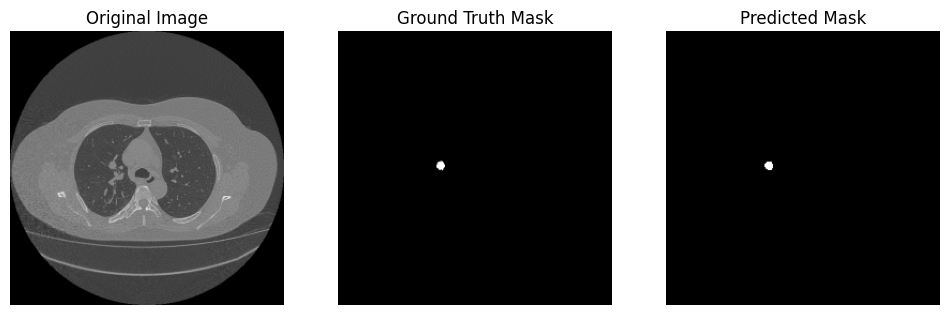

 13%|█▎        | 13/97 [00:09<00:28,  2.99it/s]

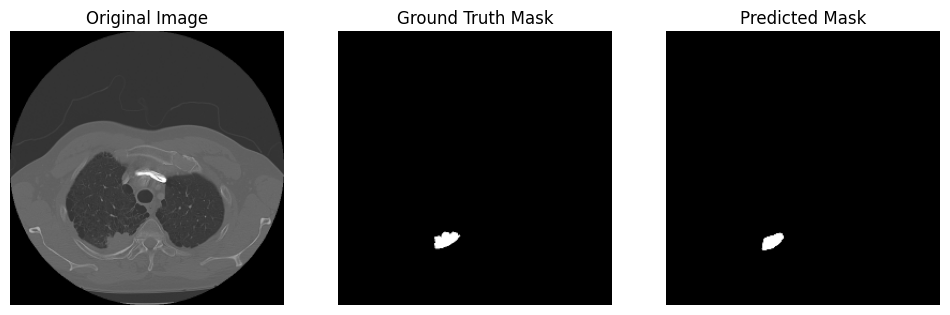

 14%|█▍        | 14/97 [00:09<00:27,  2.97it/s]

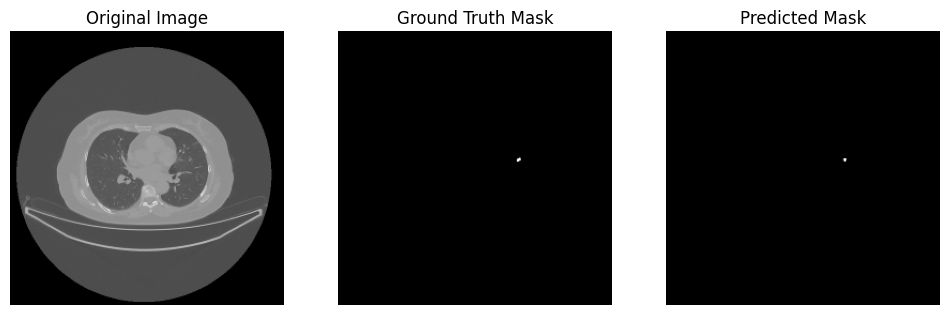

 15%|█▌        | 15/97 [00:09<00:26,  3.05it/s]

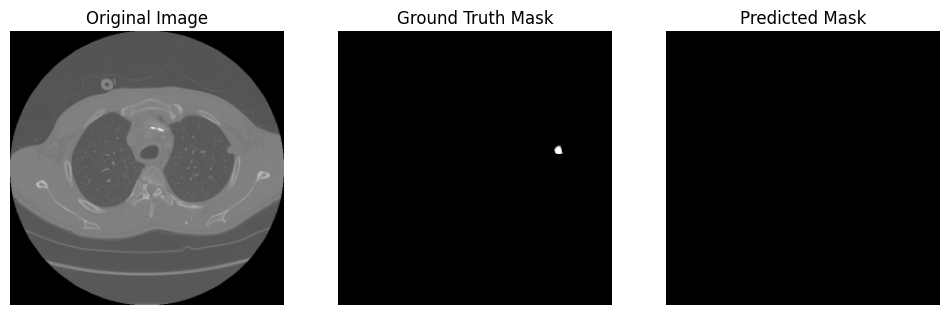

 16%|█▋        | 16/97 [00:10<00:25,  3.13it/s]

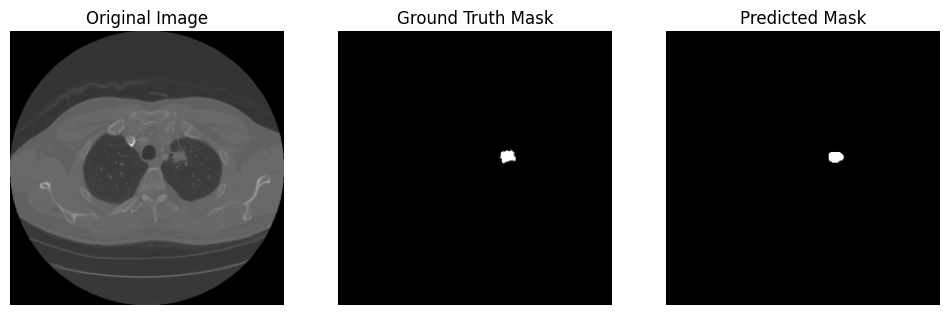

 18%|█▊        | 17/97 [00:10<00:24,  3.20it/s]

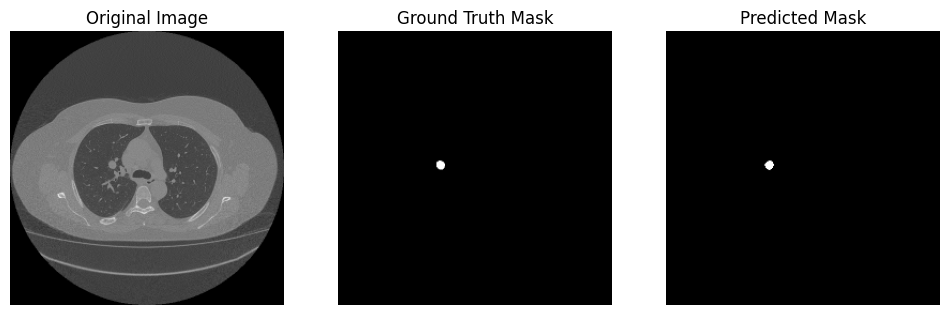

 19%|█▊        | 18/97 [00:10<00:24,  3.21it/s]

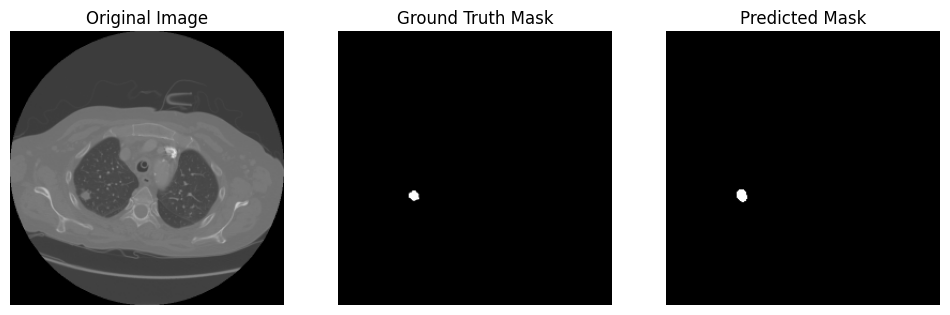

 20%|█▉        | 19/97 [00:10<00:23,  3.26it/s]

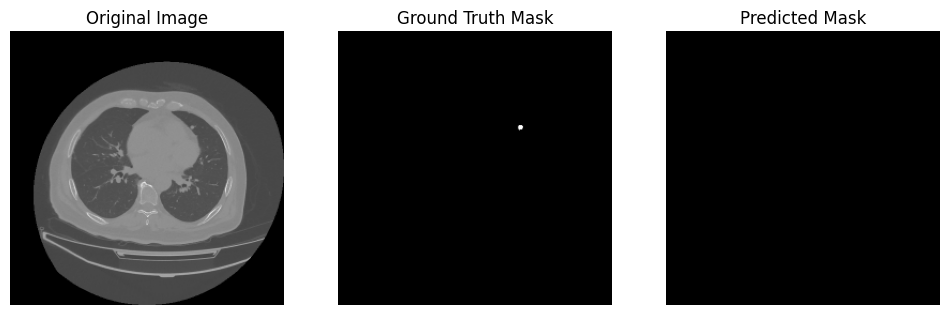

 21%|██        | 20/97 [00:11<00:23,  3.30it/s]

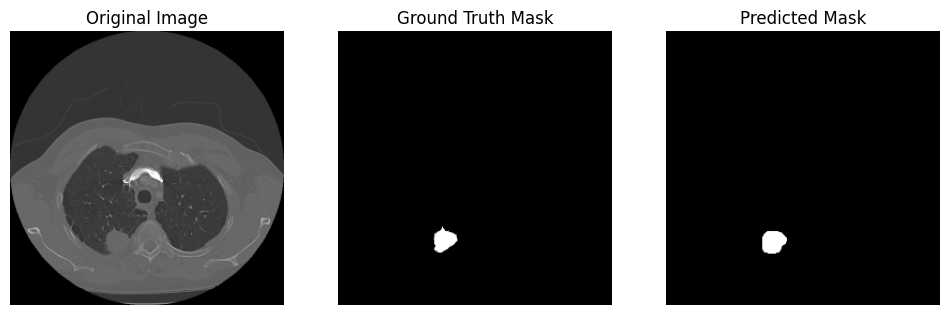

 22%|██▏       | 21/97 [00:11<00:22,  3.31it/s]

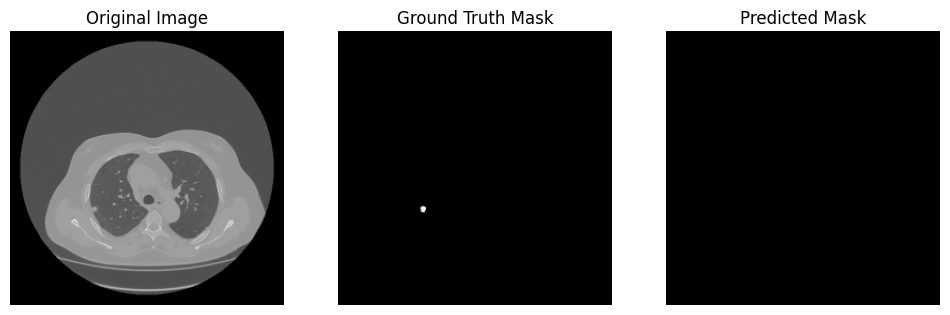

 23%|██▎       | 22/97 [00:11<00:22,  3.34it/s]

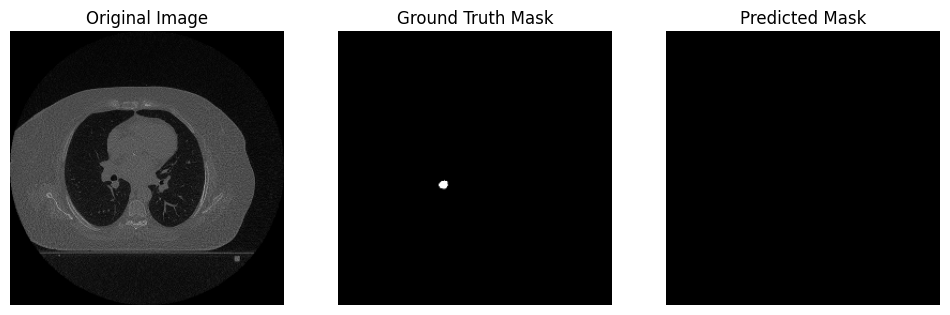

 24%|██▎       | 23/97 [00:12<00:22,  3.33it/s]

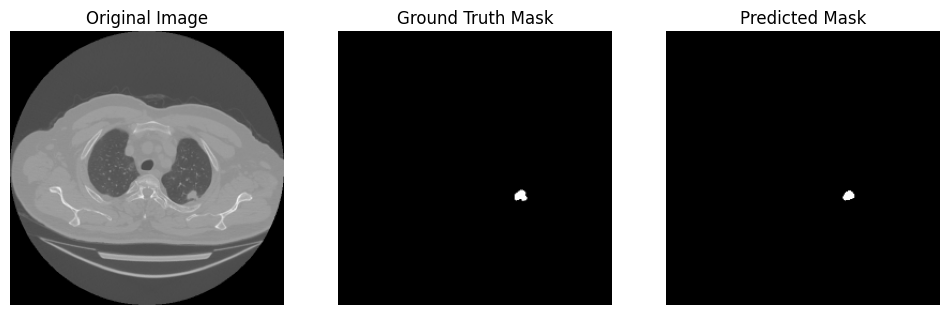

 25%|██▍       | 24/97 [00:12<00:22,  3.30it/s]

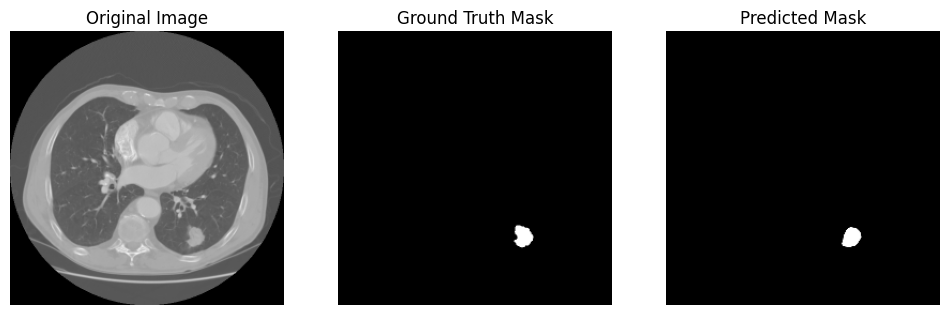

 26%|██▌       | 25/97 [00:12<00:21,  3.31it/s]

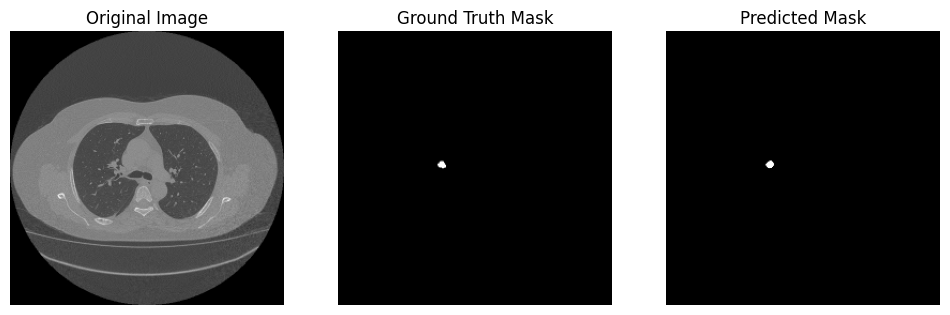

 27%|██▋       | 26/97 [00:13<00:30,  2.36it/s]

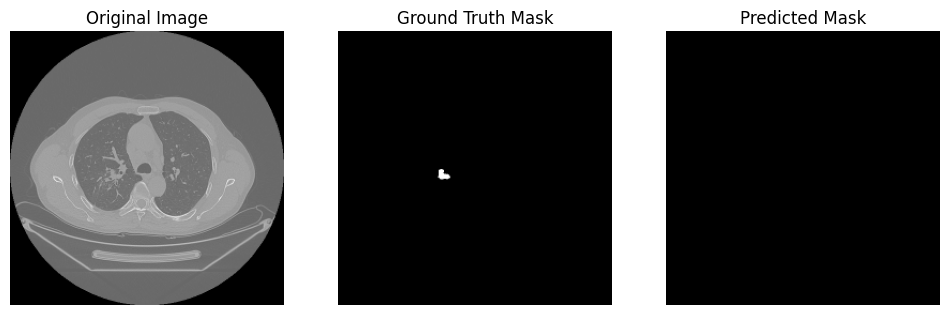

 28%|██▊       | 27/97 [00:13<00:27,  2.57it/s]

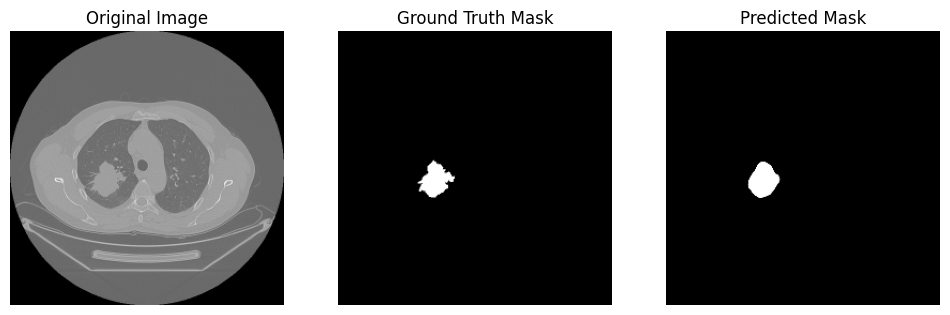

 29%|██▉       | 28/97 [00:14<00:25,  2.75it/s]

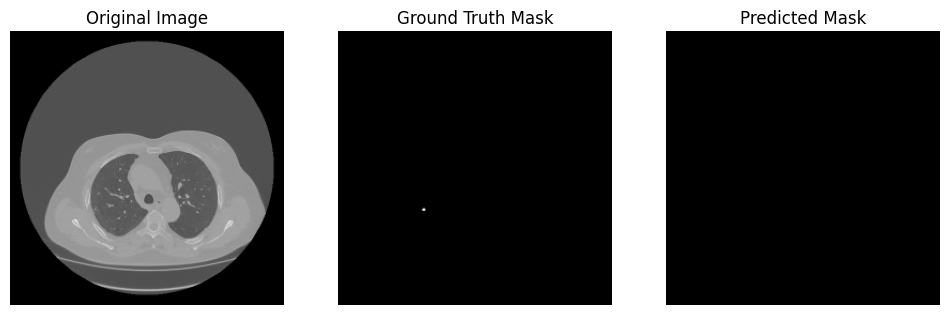

 30%|██▉       | 29/97 [00:14<00:23,  2.91it/s]

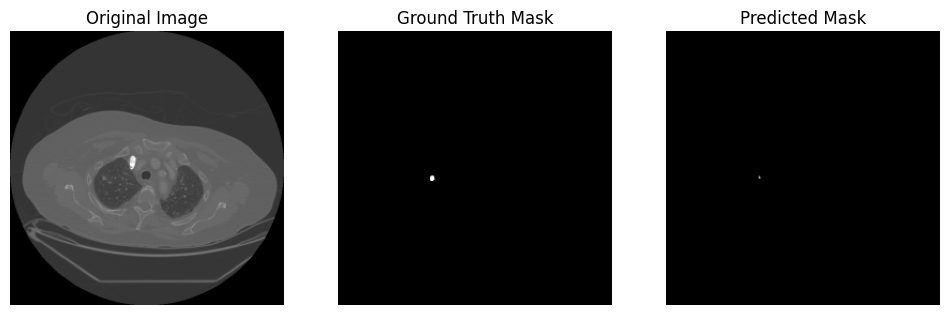

 31%|███       | 30/97 [00:14<00:22,  3.03it/s]

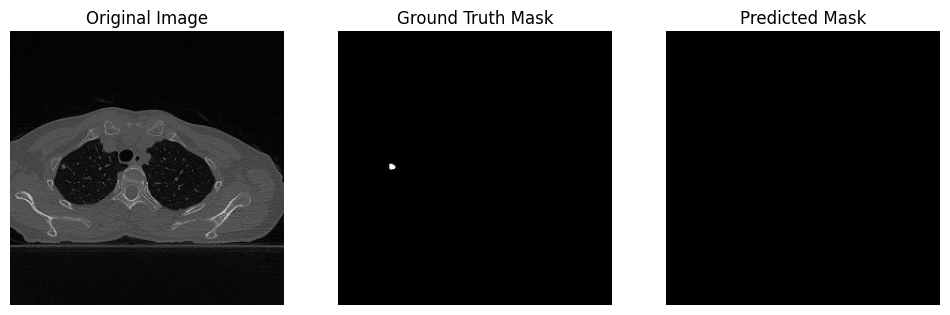

 32%|███▏      | 31/97 [00:14<00:21,  3.09it/s]

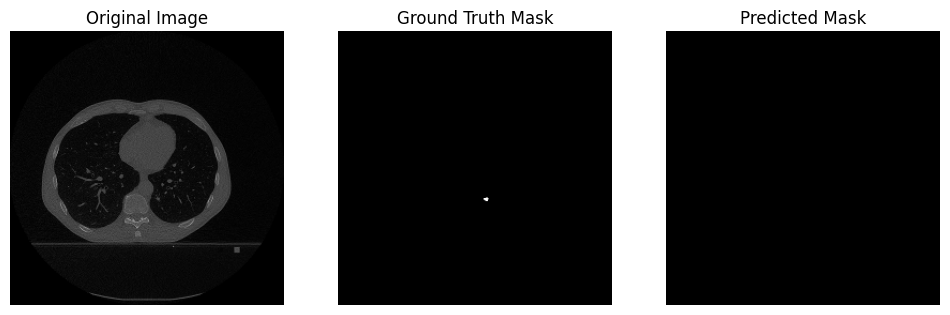

 33%|███▎      | 32/97 [00:15<00:20,  3.15it/s]

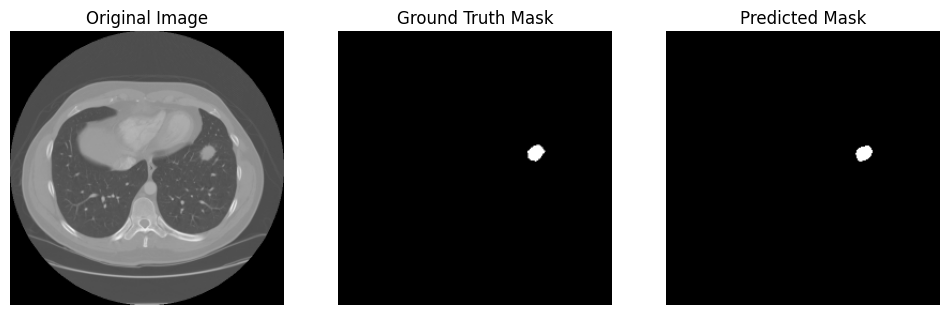

 34%|███▍      | 33/97 [00:15<00:19,  3.21it/s]

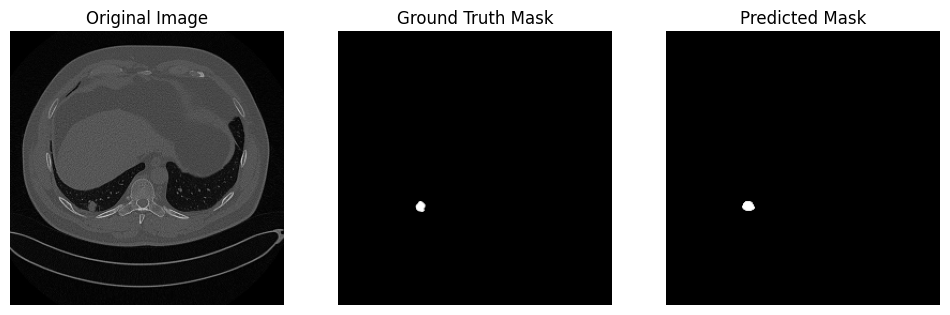

 35%|███▌      | 34/97 [00:15<00:19,  3.22it/s]

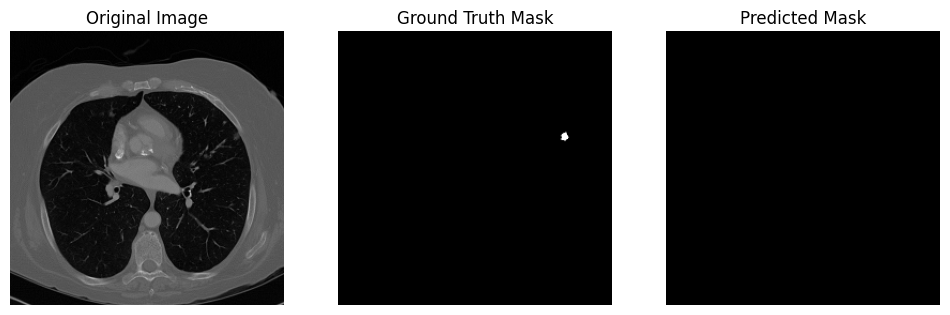

 36%|███▌      | 35/97 [00:16<00:19,  3.22it/s]

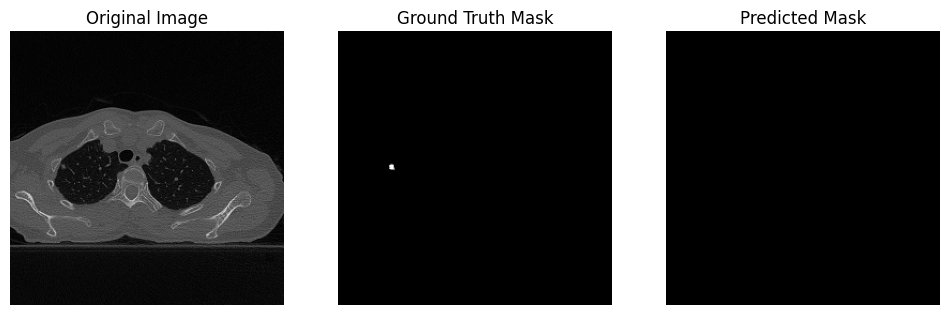

 37%|███▋      | 36/97 [00:16<00:18,  3.23it/s]

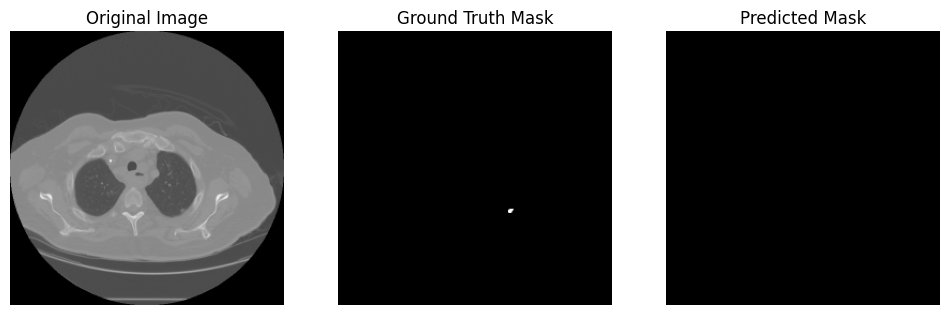

 38%|███▊      | 37/97 [00:16<00:18,  3.27it/s]

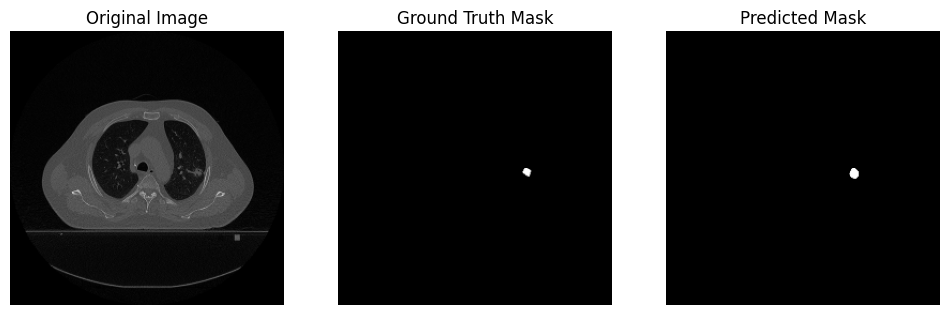

 39%|███▉      | 38/97 [00:17<00:17,  3.29it/s]

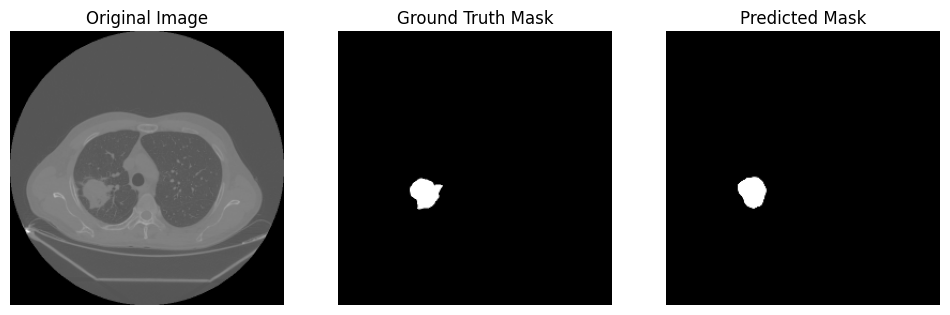

 40%|████      | 39/97 [00:17<00:17,  3.32it/s]

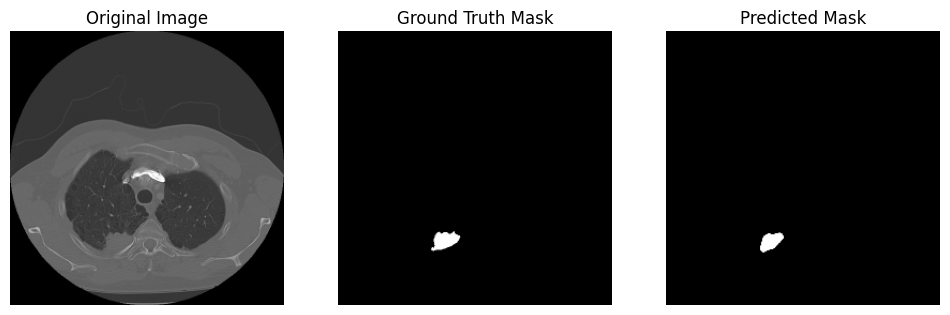

 41%|████      | 40/97 [00:17<00:17,  3.31it/s]

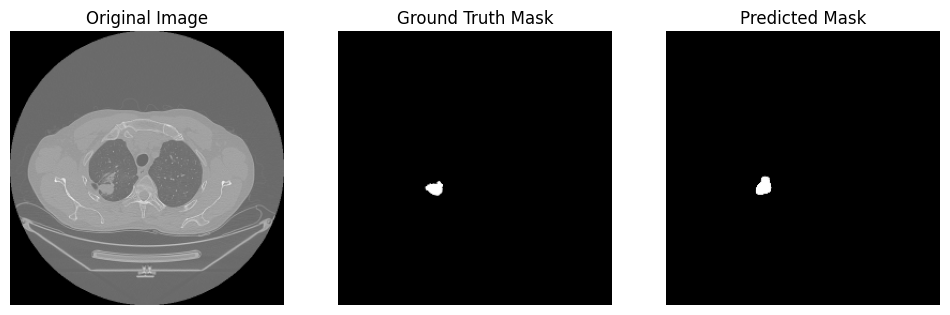

 42%|████▏     | 41/97 [00:17<00:16,  3.32it/s]

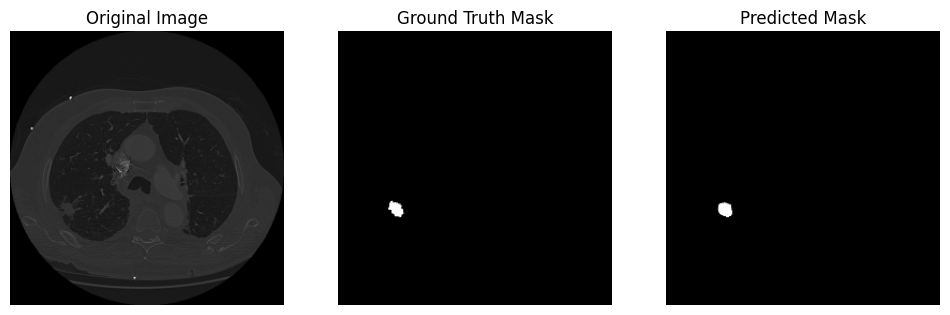

 43%|████▎     | 42/97 [00:18<00:16,  3.34it/s]

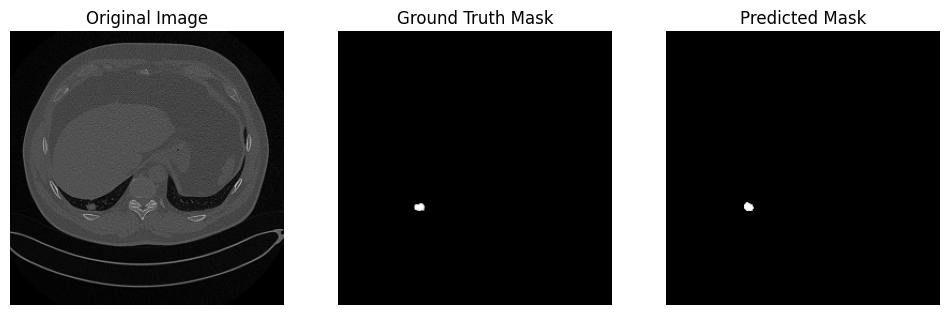

 44%|████▍     | 43/97 [00:18<00:16,  3.32it/s]

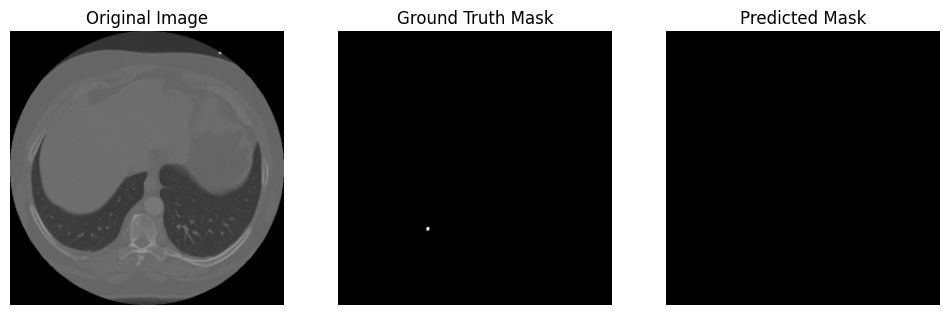

 45%|████▌     | 44/97 [00:18<00:15,  3.33it/s]

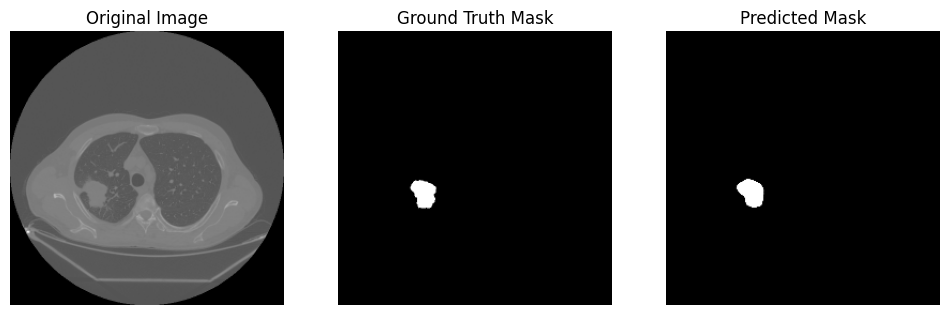

 46%|████▋     | 45/97 [00:19<00:15,  3.34it/s]

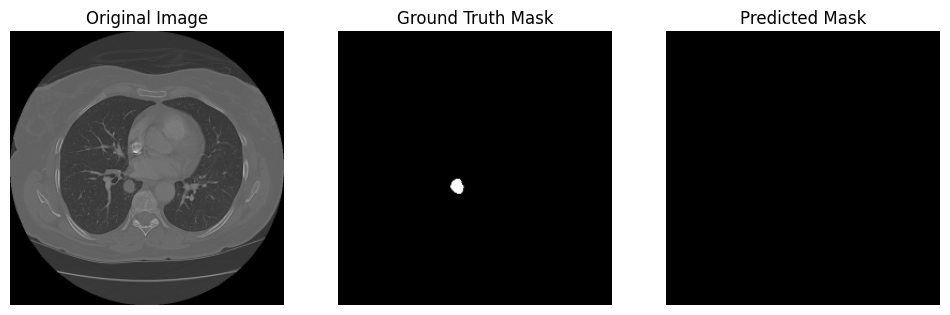

 47%|████▋     | 46/97 [00:19<00:15,  3.23it/s]

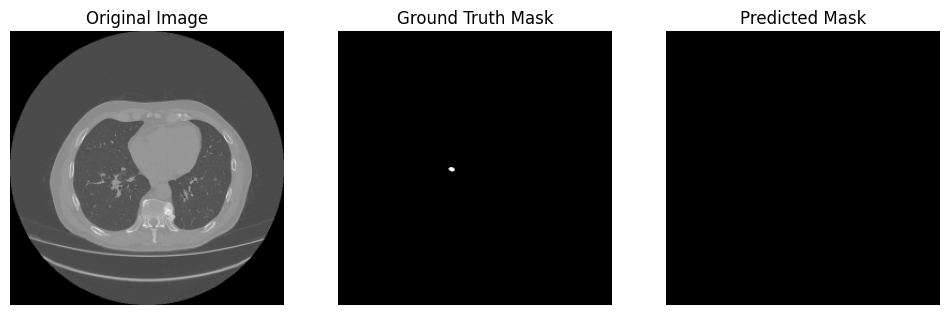

 48%|████▊     | 47/97 [00:19<00:15,  3.28it/s]

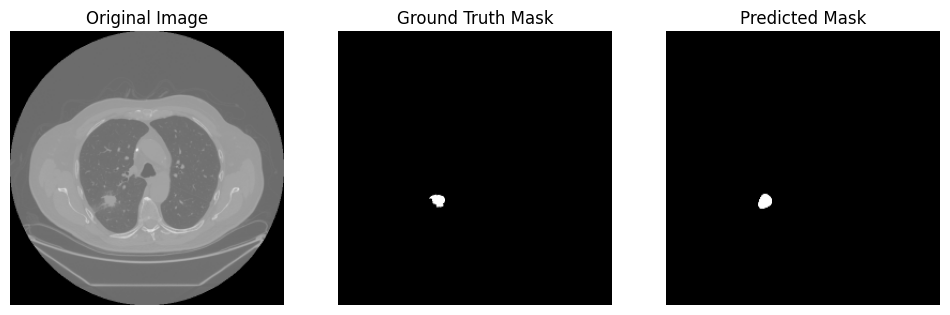

 49%|████▉     | 48/97 [00:20<00:14,  3.32it/s]

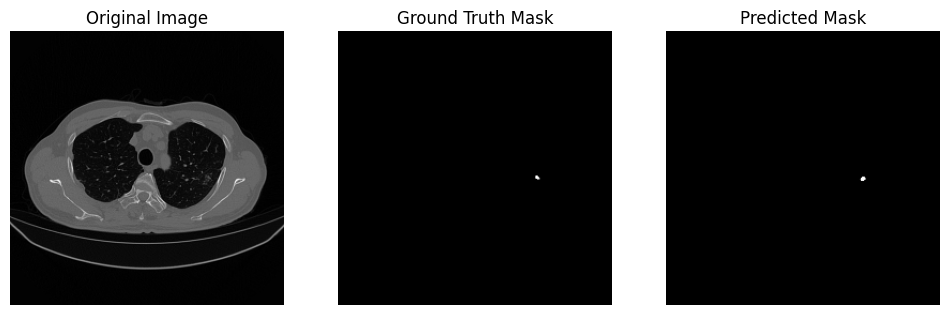

 51%|█████     | 49/97 [00:20<00:14,  3.33it/s]

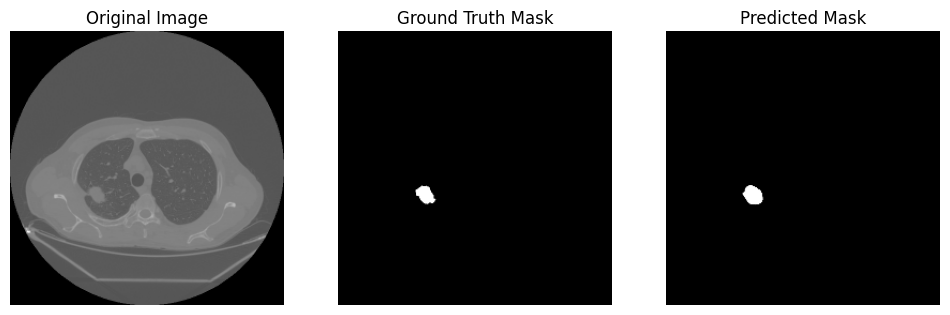

 52%|█████▏    | 50/97 [00:20<00:14,  3.34it/s]

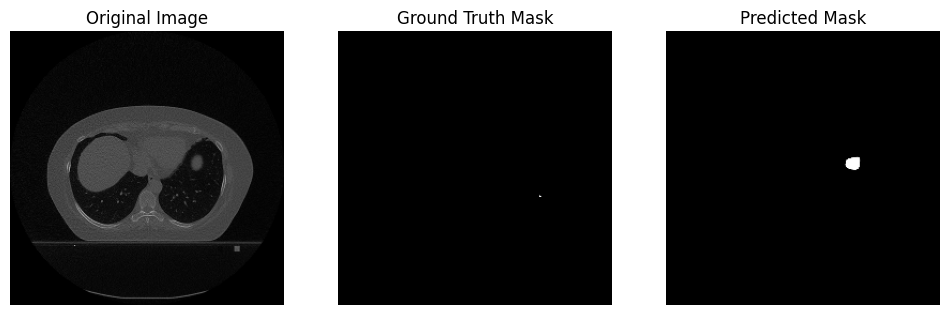

 53%|█████▎    | 51/97 [00:21<00:19,  2.33it/s]

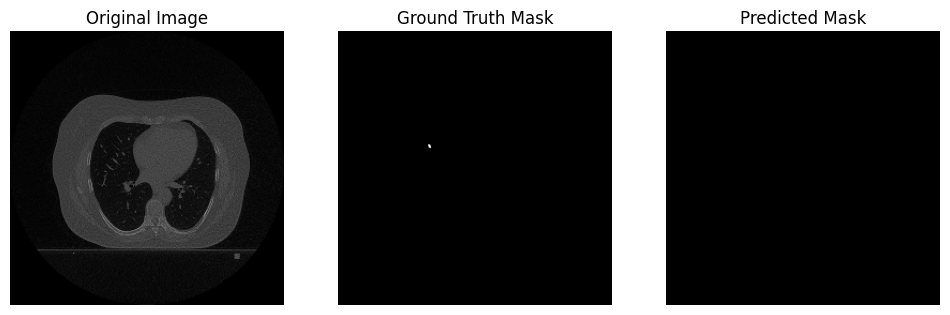

 54%|█████▎    | 52/97 [00:21<00:17,  2.55it/s]

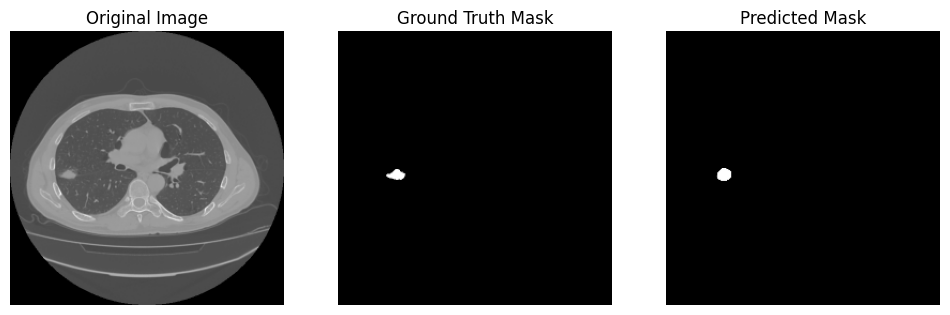

 55%|█████▍    | 53/97 [00:22<00:16,  2.73it/s]

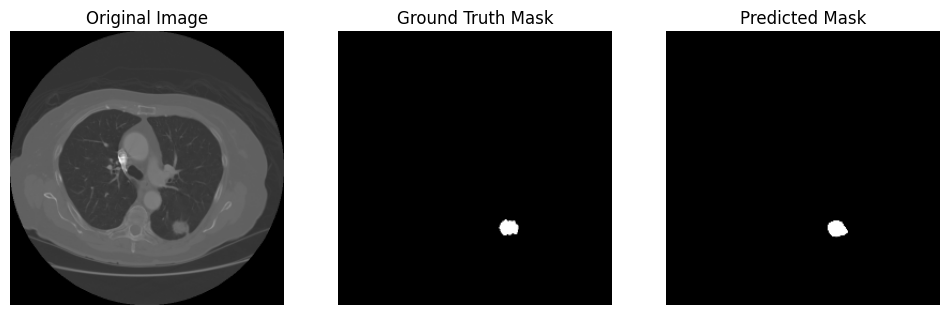

 56%|█████▌    | 54/97 [00:22<00:14,  2.88it/s]

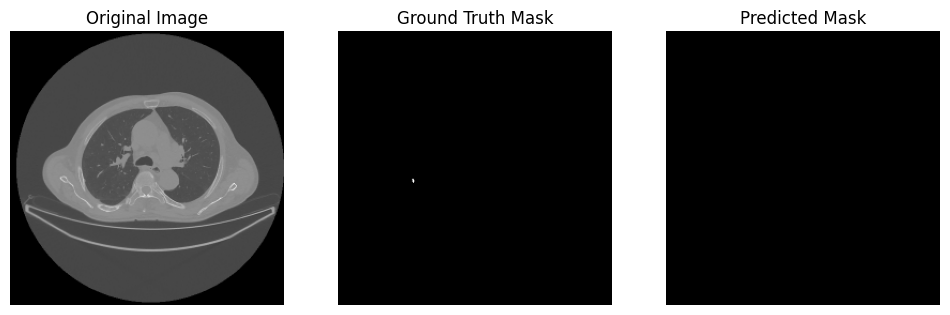

 57%|█████▋    | 55/97 [00:22<00:14,  2.98it/s]

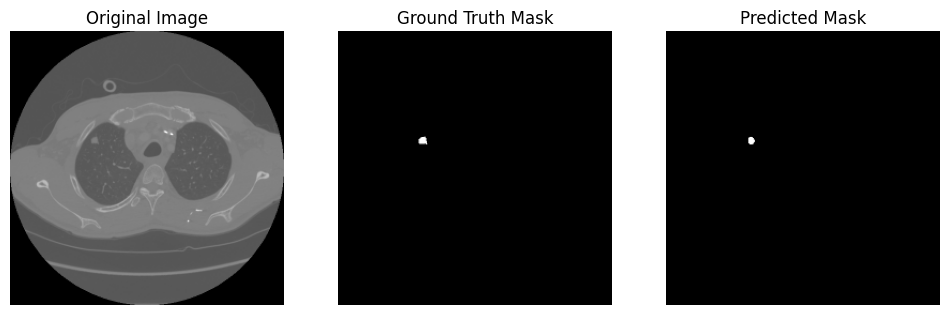

 58%|█████▊    | 56/97 [00:22<00:13,  3.07it/s]

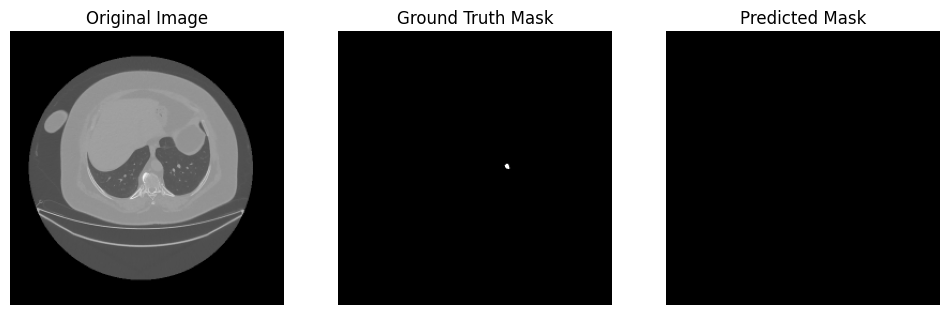

 59%|█████▉    | 57/97 [00:23<00:12,  3.17it/s]

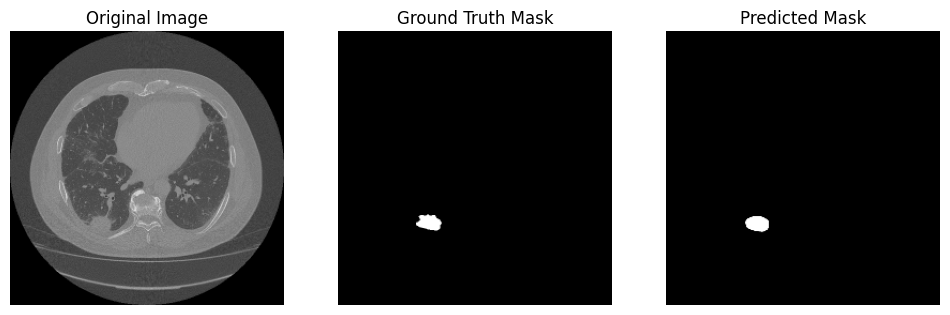

 60%|█████▉    | 58/97 [00:23<00:12,  3.20it/s]

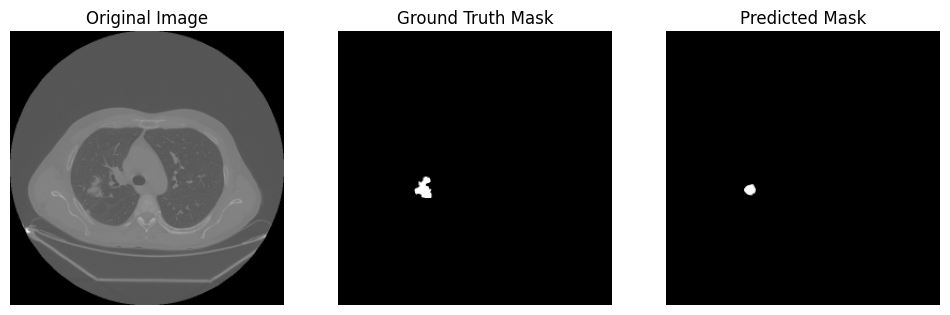

 61%|██████    | 59/97 [00:23<00:11,  3.25it/s]

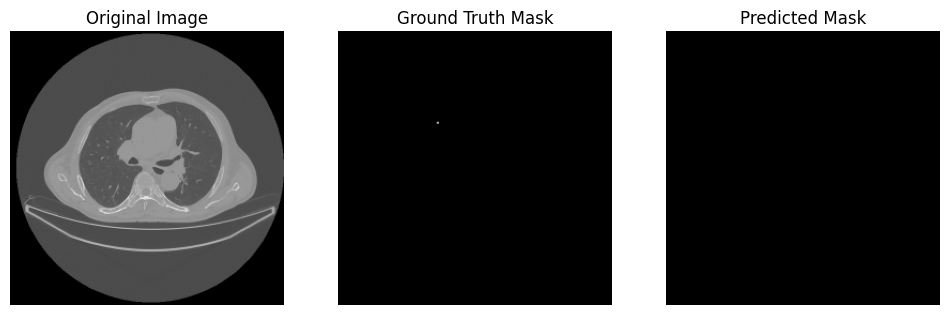

 62%|██████▏   | 60/97 [00:24<00:11,  3.29it/s]

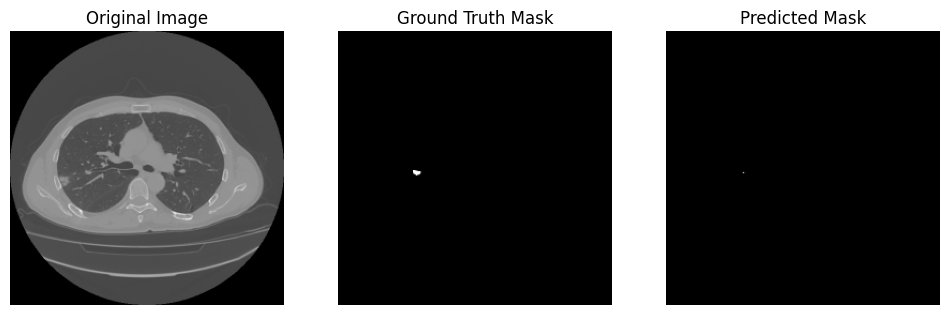

 63%|██████▎   | 61/97 [00:24<00:10,  3.32it/s]

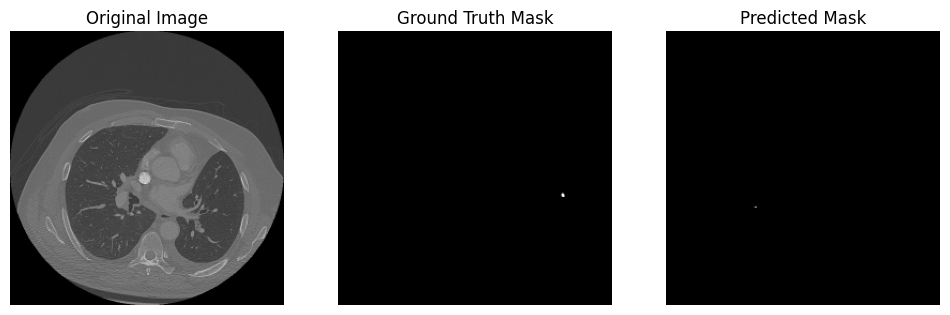

 64%|██████▍   | 62/97 [00:24<00:10,  3.32it/s]

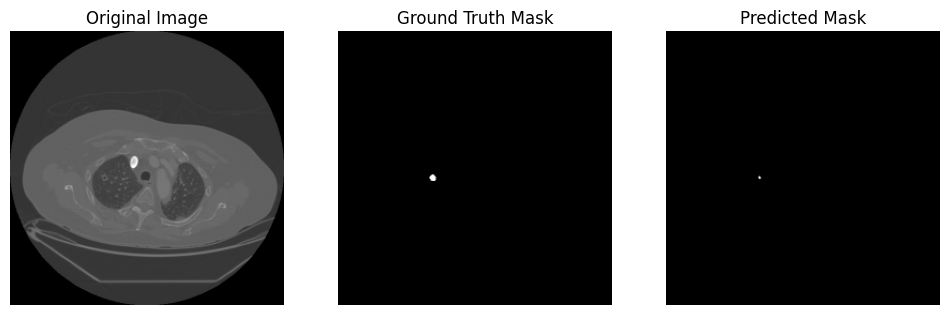

 65%|██████▍   | 63/97 [00:25<00:10,  3.35it/s]

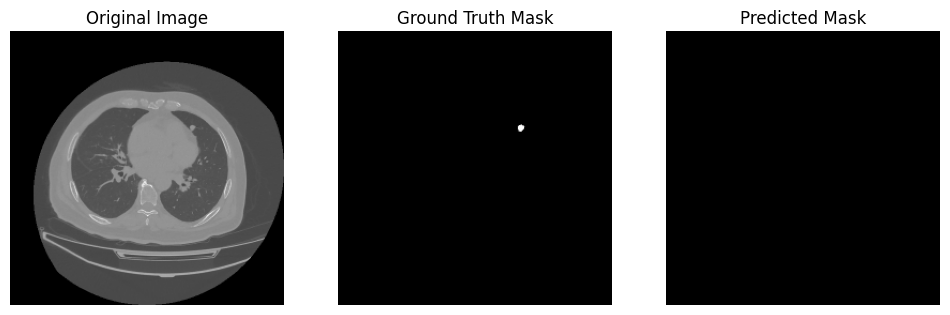

 66%|██████▌   | 64/97 [00:25<00:09,  3.38it/s]

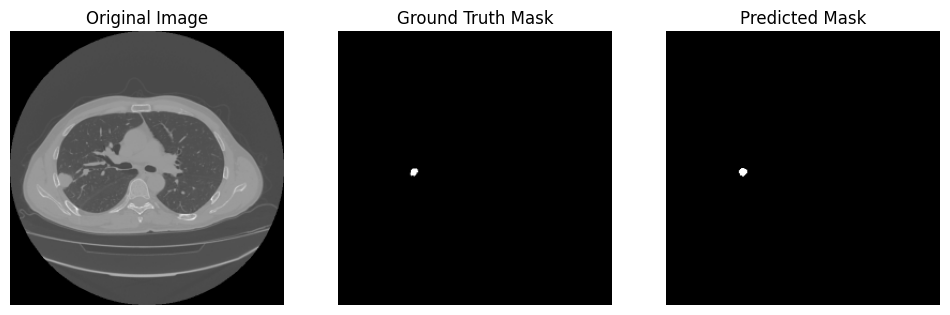

 67%|██████▋   | 65/97 [00:25<00:09,  3.38it/s]

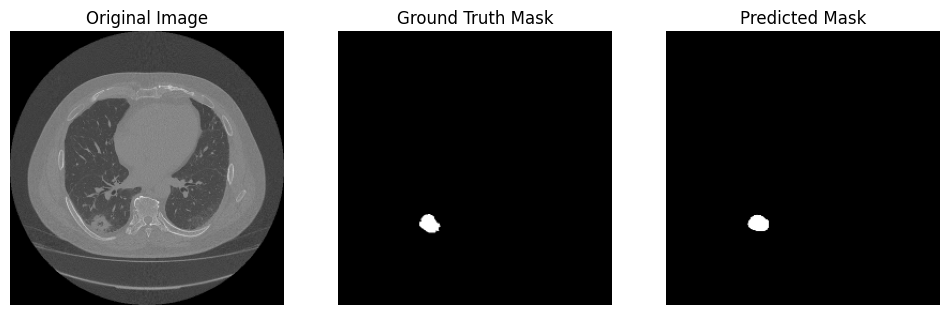

 68%|██████▊   | 66/97 [00:25<00:09,  3.37it/s]

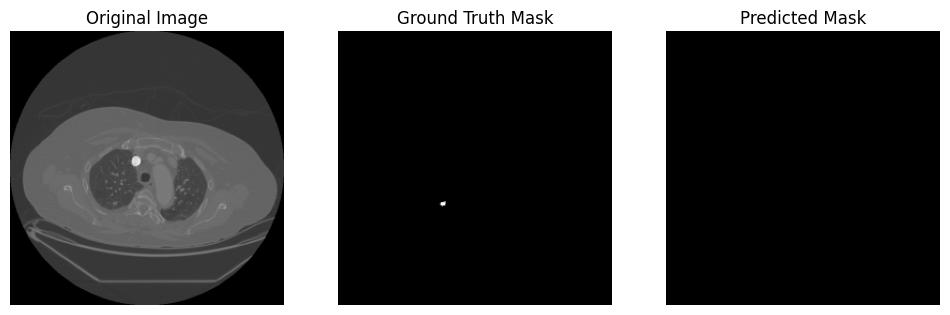

 69%|██████▉   | 67/97 [00:26<00:08,  3.38it/s]

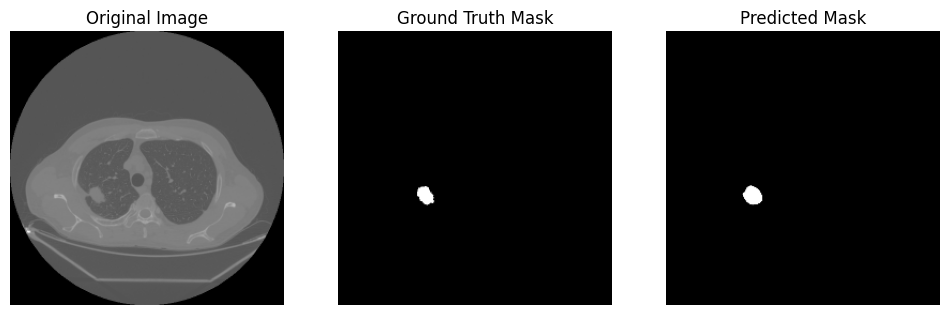

 70%|███████   | 68/97 [00:26<00:08,  3.39it/s]

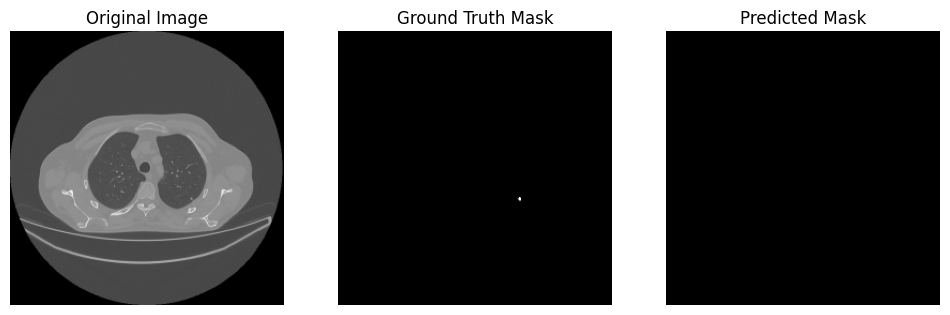

 71%|███████   | 69/97 [00:26<00:08,  3.39it/s]

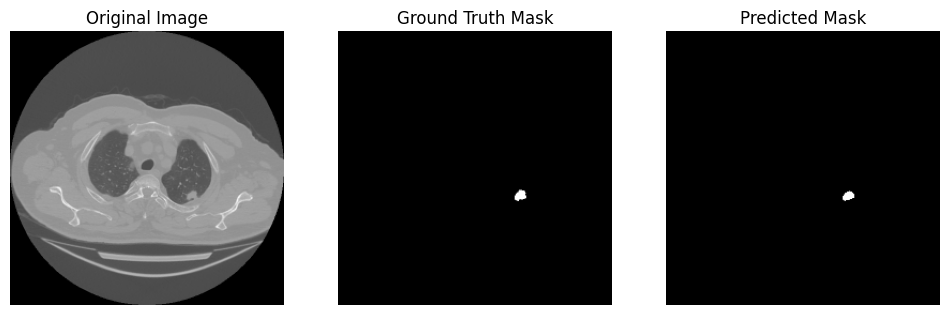

 72%|███████▏  | 70/97 [00:27<00:08,  3.37it/s]

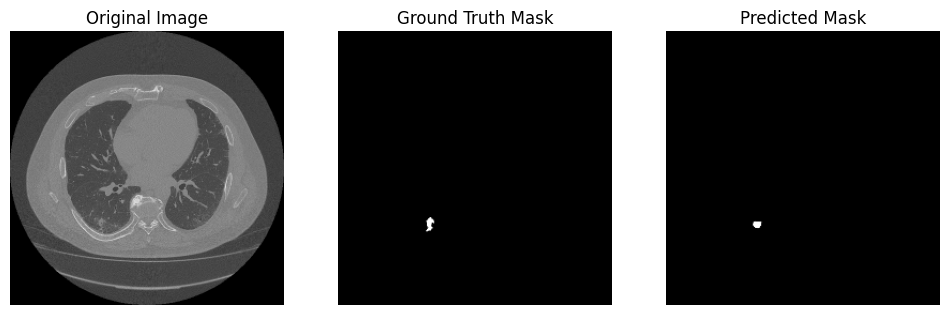

 73%|███████▎  | 71/97 [00:27<00:07,  3.36it/s]

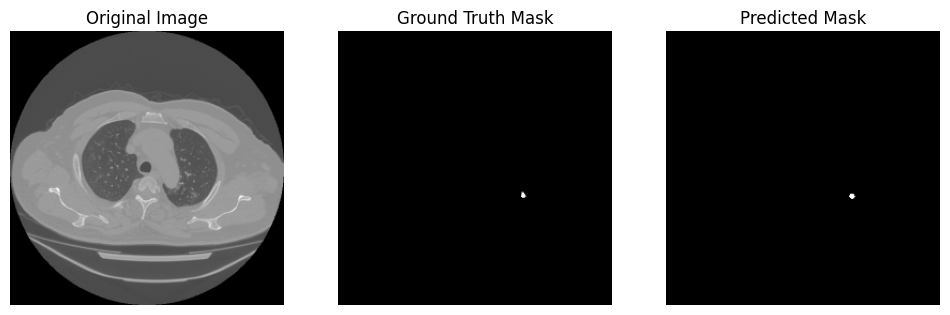

 74%|███████▍  | 72/97 [00:27<00:07,  3.35it/s]

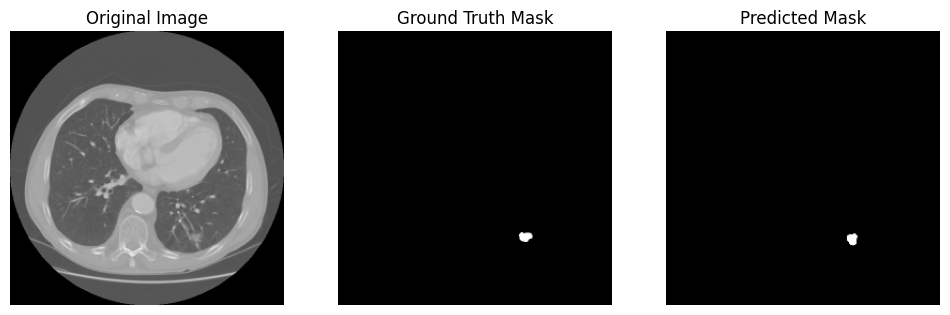

 75%|███████▌  | 73/97 [00:28<00:07,  3.36it/s]

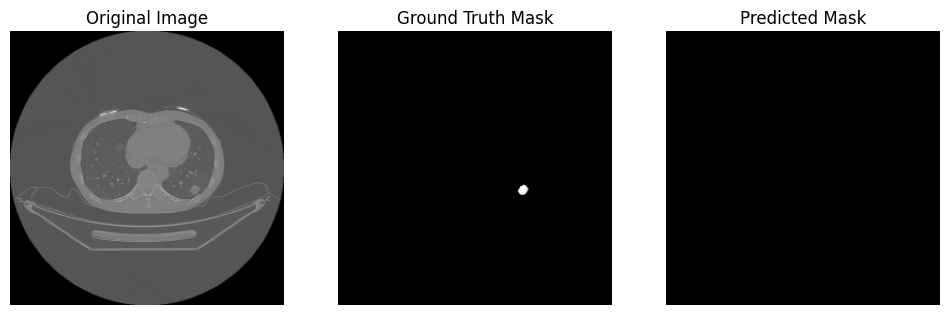

 76%|███████▋  | 74/97 [00:28<00:09,  2.33it/s]

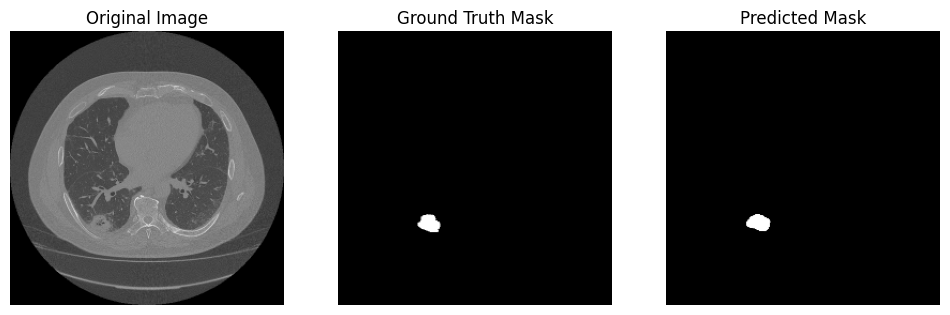

 77%|███████▋  | 75/97 [00:29<00:08,  2.52it/s]

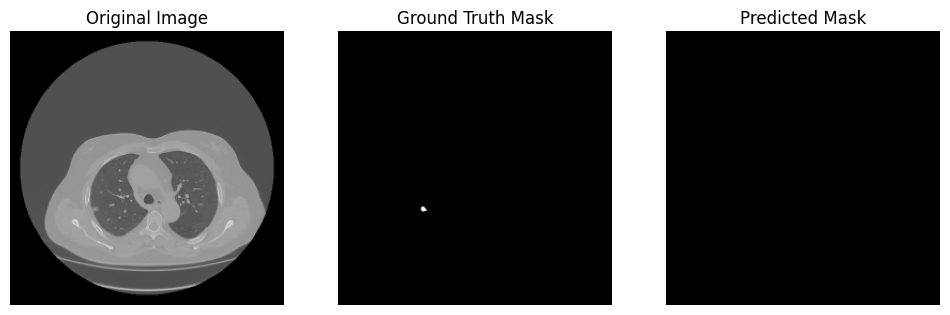

 78%|███████▊  | 76/97 [00:29<00:07,  2.66it/s]

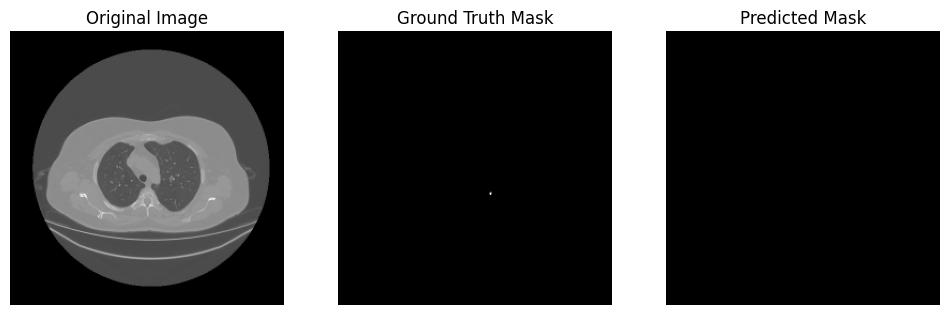

 79%|███████▉  | 77/97 [00:29<00:07,  2.76it/s]

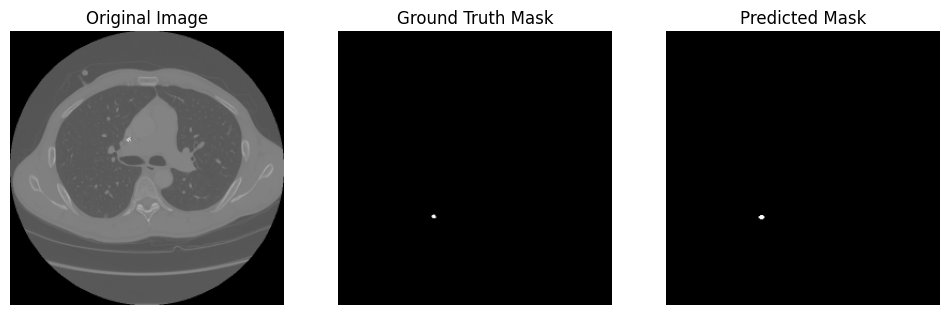

 80%|████████  | 78/97 [00:30<00:06,  2.92it/s]

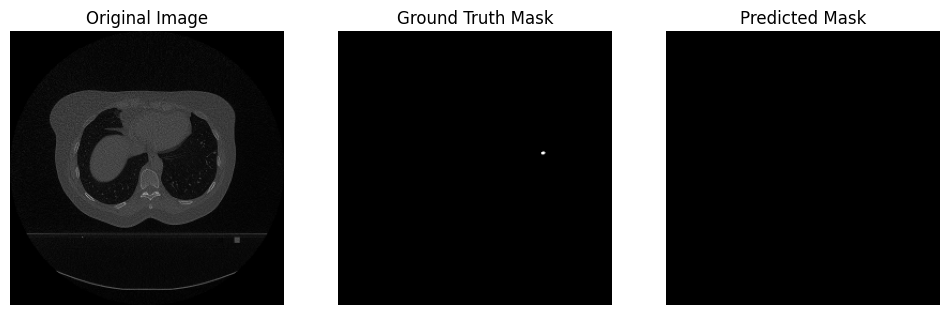

 81%|████████▏ | 79/97 [00:30<00:05,  3.02it/s]

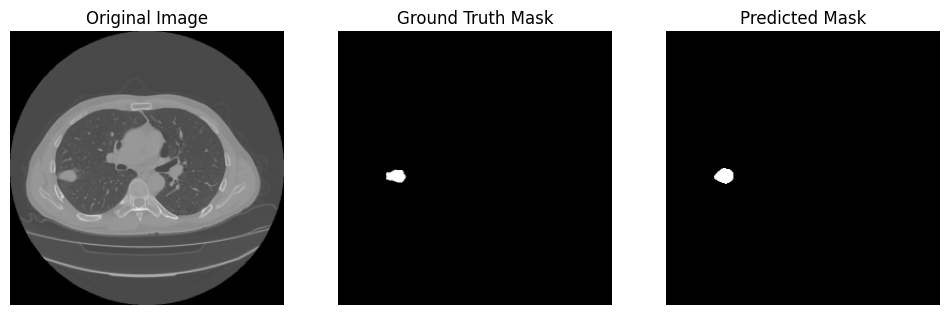

 82%|████████▏ | 80/97 [00:30<00:05,  3.08it/s]

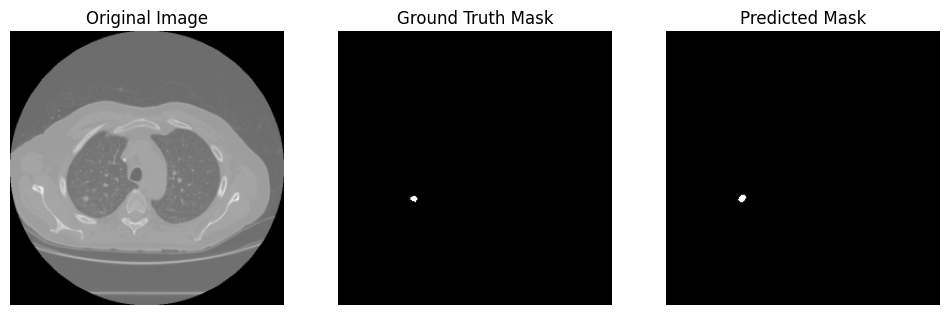

 84%|████████▎ | 81/97 [00:30<00:05,  3.09it/s]

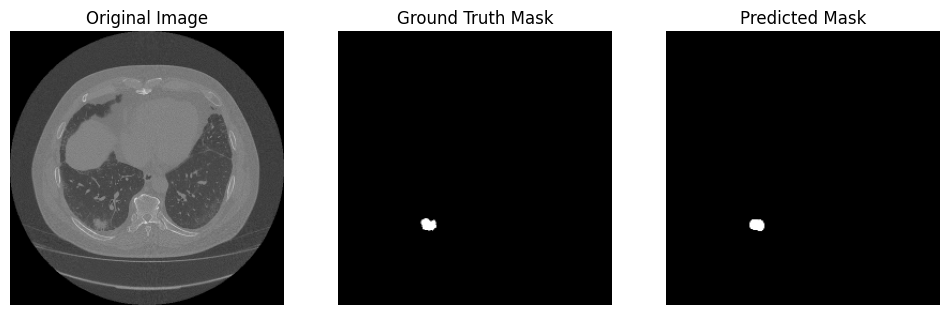

 85%|████████▍ | 82/97 [00:31<00:04,  3.14it/s]

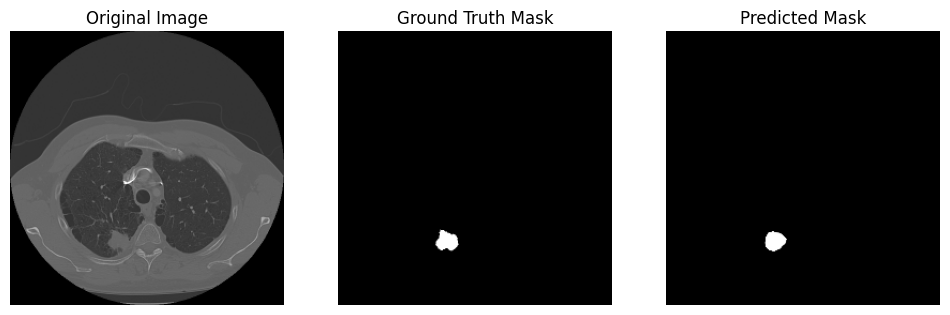

 86%|████████▌ | 83/97 [00:31<00:04,  3.21it/s]

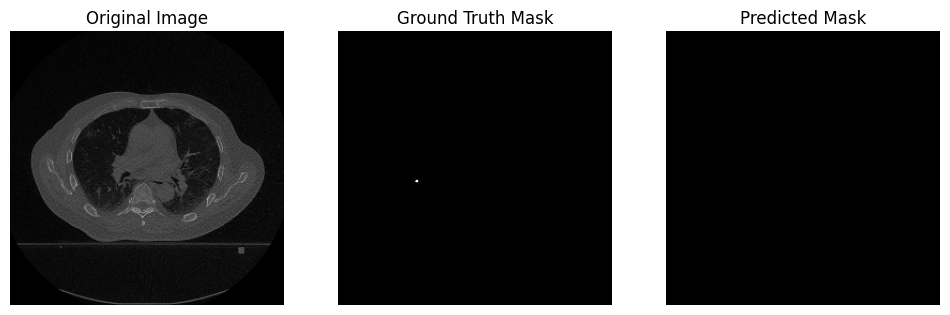

 87%|████████▋ | 84/97 [00:31<00:04,  3.22it/s]

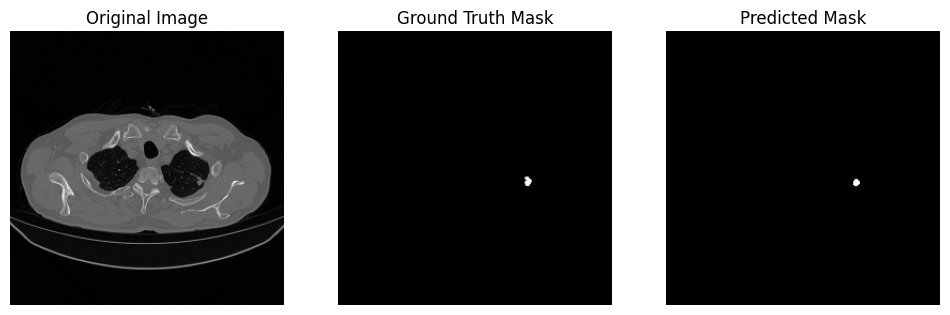

 88%|████████▊ | 85/97 [00:32<00:03,  3.24it/s]

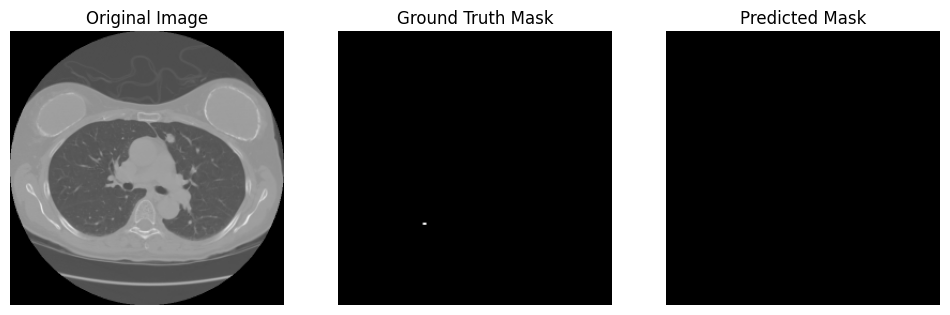

 89%|████████▊ | 86/97 [00:32<00:03,  3.29it/s]

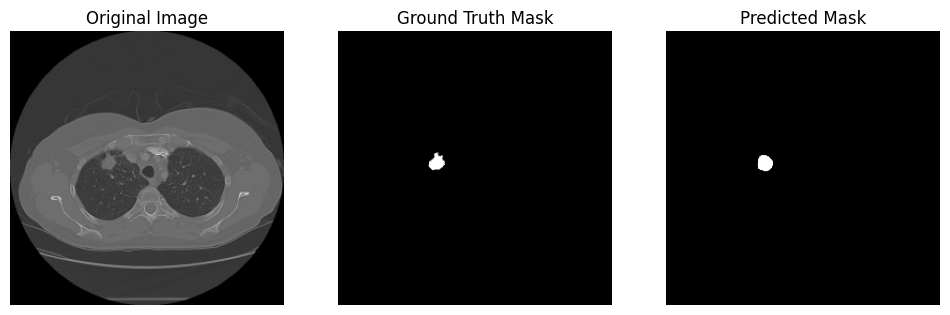

 90%|████████▉ | 87/97 [00:32<00:03,  3.30it/s]

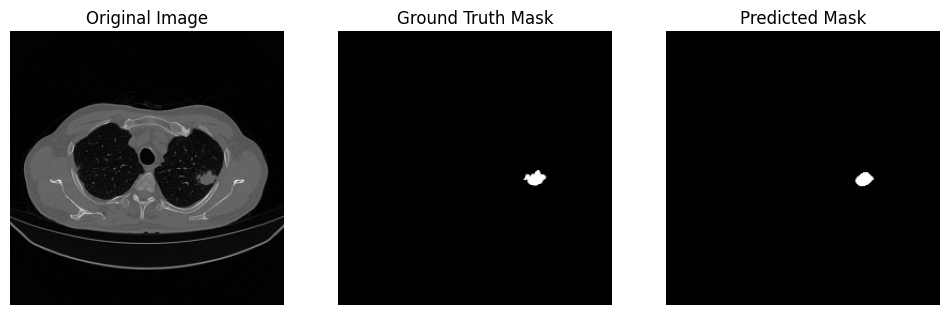

 91%|█████████ | 88/97 [00:33<00:02,  3.29it/s]

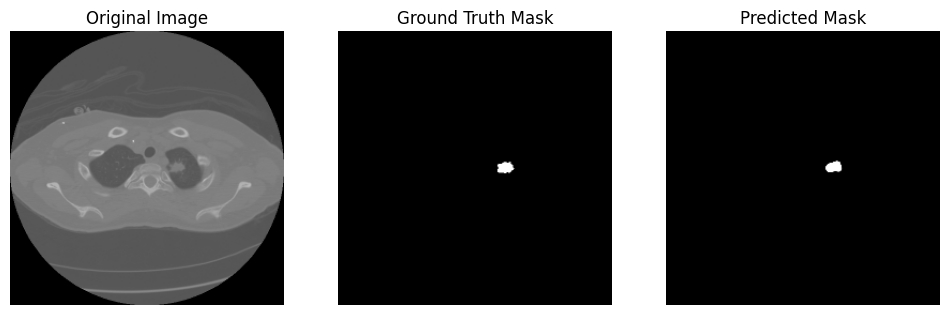

 92%|█████████▏| 89/97 [00:33<00:02,  3.33it/s]

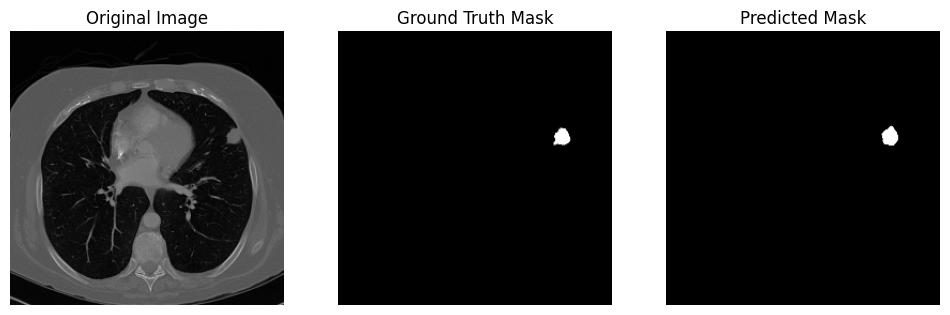

 93%|█████████▎| 90/97 [00:33<00:02,  3.30it/s]

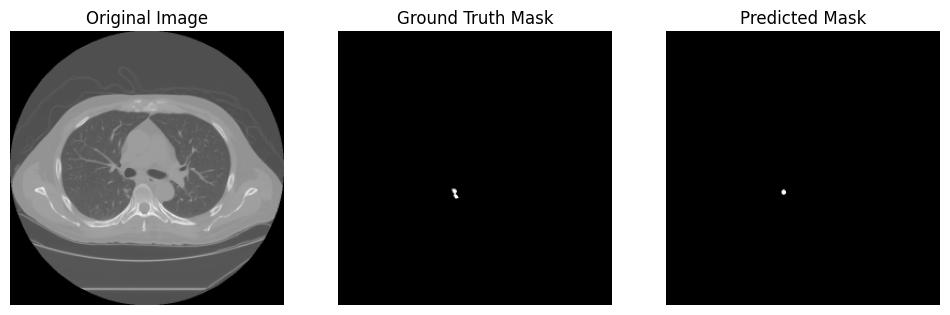

 94%|█████████▍| 91/97 [00:33<00:01,  3.29it/s]

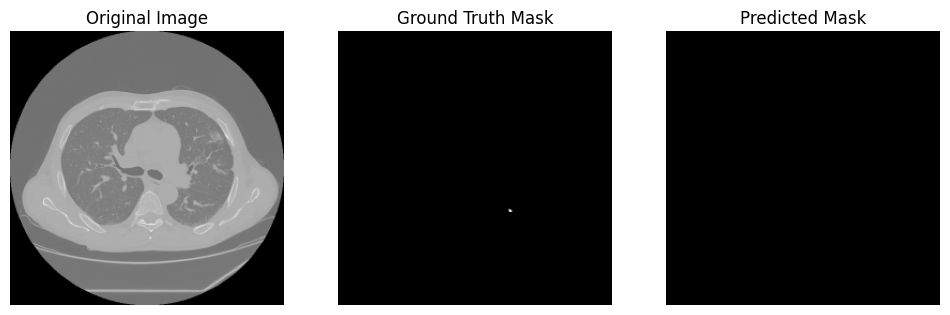

 95%|█████████▍| 92/97 [00:34<00:01,  3.30it/s]

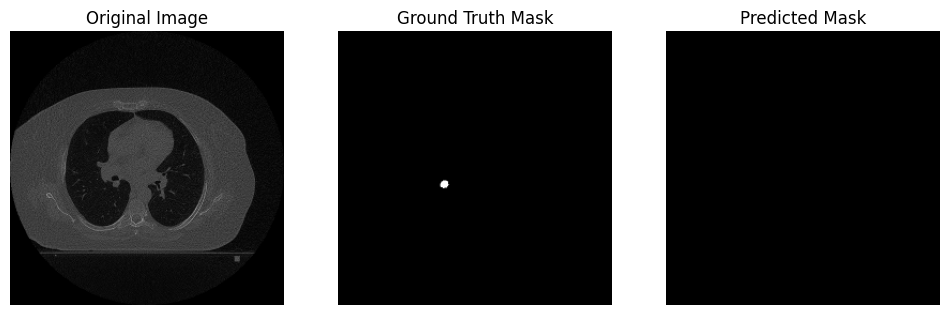

 96%|█████████▌| 93/97 [00:34<00:01,  3.30it/s]

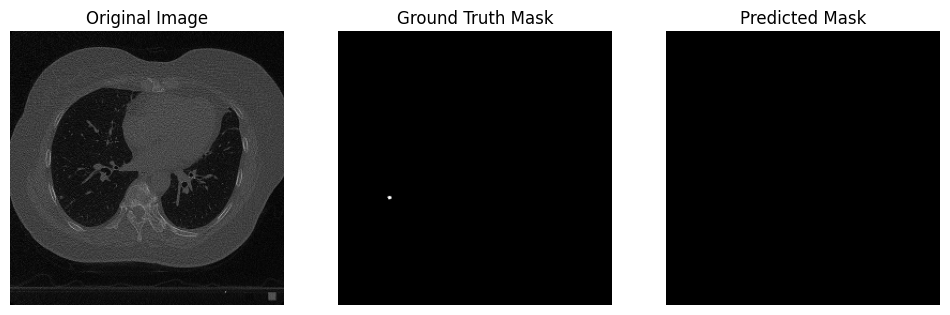

 97%|█████████▋| 94/97 [00:34<00:00,  3.30it/s]

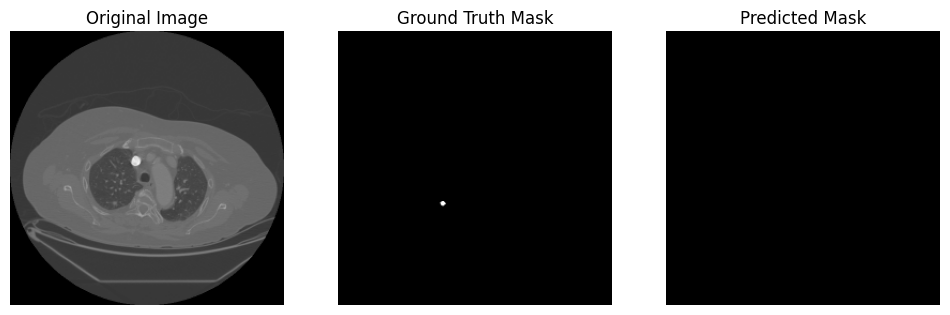

 98%|█████████▊| 95/97 [00:35<00:00,  3.32it/s]

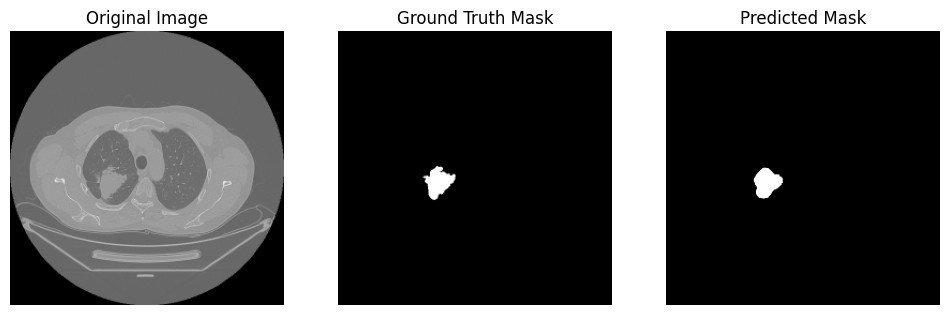

 99%|█████████▉| 96/97 [00:35<00:00,  3.33it/s]

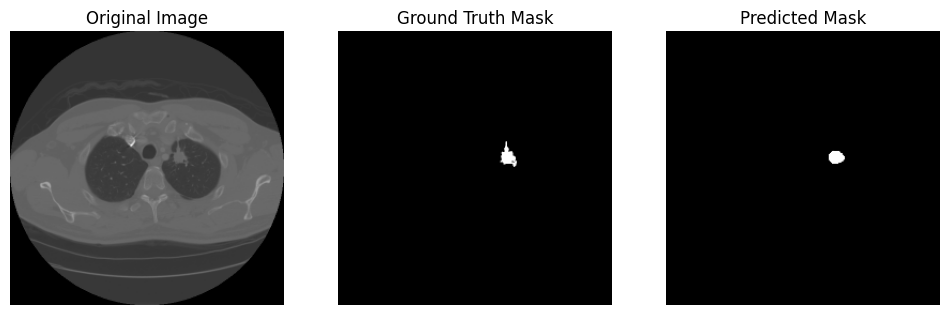

100%|██████████| 97/97 [00:35<00:00,  2.71it/s]


In [15]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
# Assuming other imports like load_data, dice_loss, dice_coef, and patchify are handled.

# UNETR Configuration
cf = {}
cf["image_size"] = 256
cf["num_channels"] = 3
cf["num_layers"] = 12
cf["hidden_dim"] = 128
cf["mlp_dim"] = 32
cf["num_heads"] = 6
cf["dropout_rate"] = 0.1
cf["patch_size"] = 16
cf["num_patches"] = (cf["image_size"]**2) // (cf["patch_size"]**2)
cf["flat_patches_shape"] = (
    cf["num_patches"],
    cf["patch_size"]*cf["patch_size"]*cf["num_channels"]
)

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    # create_dir(f"results")

    """ Load the model """
    model_path = os.path.join("/kaggle/working/save_weights_dataset_2", "/kaggle/working/save_weights_dataset_2/Unettr_2D.keras")
    model = tf.keras.models.load_model(model_path, custom_objects={"dice_loss": dice_loss, "dice_coef": dice_coef, "iou":iou_coef})

    """ Dataset """
    dataset_path = "/kaggle/input/training-data-for-lung-canceraugmented"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)

    print(f"Train: \t{len(train_x)} - {len(train_y)}")
    print(f"Valid: \t{len(valid_x)} - {len(valid_y)}")
    print(f"Test: \t{len(test_x)} - {len(test_y)}")

    """ Prediction """
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        """ Extracting the name """
        name = x.split("/")[-1]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
        x = image / 255.0

        patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
        patches = patchify(x, patch_shape, cf["patch_size"])
        patches = np.reshape(patches, cf["flat_patches_shape"])
        patches = patches.astype(np.float32)
        patches = np.expand_dims(patches, axis=0)

        """ Read Mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (cf["image_size"], cf["image_size"]))
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=-1)
        mask = np.concatenate([mask, mask, mask], axis=-1)

        """ Prediction """
        pred = model.predict(patches, verbose=0)[0]
        pred = np.concatenate([pred, pred, pred], axis=-1)

        """ Plotting the result using Matplotlib """
        plt.figure(figsize=(12, 4))

        # Plot original image
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')

        # Plot ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Plot predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(pred)
        plt.title('Predicted Mask')
        plt.axis('off')

        # Show the plot
        plt.show()



In [16]:
# """ Evaluate the Model on Test Set """
# test_dataset = tf_dataset(test_x, test_y, batch=8)  # Adjust batch size as needed

# test_loss, test_dice_coef, test_iou_coef, test_precision, test_recall, test_f1_score, test_acc = model.evaluate(test_dataset, verbose=1)

# print("=" * 50)
# print("Overall Test Metrics:")
# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test Dice Coefficient: {test_dice_coef:.4f}")
# print(f"Test IoU Coefficient: {test_iou_coef:.4f}")
# print(f"Test Precision: {test_precision:.4f}")
# print(f"Test Recall: {test_recall:.4f}")
# print(f"Test F1 Score: {test_f1_score:.4f}")
# print(f"Test Accuracy: {test_acc:.4f}")
# print("=" * 50)


In [17]:
import shutil

# Zip the "results" folder
shutil.make_archive("/kaggle/working/results", 'zip', "/kaggle/working/results")

print("Zipping complete! You can now download results.zip")


Zipping complete! You can now download results.zip
